*Author & point of contact: Piotr Kaniewski (piotr@everycure.org)*

# LLM Embedding Benchmark - ML classifiers v2- full data

Repeating the classifier training but this time on full data to examine how much do the topological embeddings enrich nodes

By the end of this notebook I hope to be able to answer/understand better:
* how much topological information is being used in making predictions
* the impact of PCA on embedding's quality (in terms of downstream analysis i.e. do we lose information during PCA),
* potential data leakage.

*For exploratory analysis of the embeddings and sample data preparation refer to other notebooks*

In [219]:
import os
import joblib
import subprocess
import tqdm
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier                                    

# Setting the root path and changing the directory
root_path = subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).decode().strip()
os.chdir(Path(root_path) / 'pipelines' / 'matrix')

#%load_ext kedro.ipython
#%reload_kedro  --env base

# Node Attribute Embeddings

## Load data
Similarly to what we did in the notebook v1, we will train the classifiers on node embeddings and post-pca embeddings but this time with all nodes to examine the score distribution

In [220]:
#load metadata and gt
sample_df = pd.read_csv("gs://mtrx-us-central1-hub-dev-storage/kedro/data/01_raw/rtx_kg2/v2.7.3/nodes_c.tsv")

#load gt 
gt = pd.read_csv('gs://mtrx-us-central1-wg2-modeling-dev-storage/llm_embed_benchmark/subsample/gt.csv')

In [12]:
# load full embeddings (name + category encoded by embeddings)

#pubmedbert
pubmed_emb = np.array(joblib.load('gs://mtrx-us-central1-wg2-modeling-dev-storage/llm_embed_benchmark/full/pubmedbert_embed_full.joblib'))

# #openai
openai_emb = np.array(joblib.load('gs://mtrx-us-central1-wg2-modeling-dev-storage/llm_embed_benchmark/full/openai_full_embed.joblib'))

# #spacy
spacy_emb = np.array(joblib.load('gs://mtrx-us-central1-wg2-modeling-dev-storage/llm_embed_benchmark/full/en_core_sci_web_scispacy_embed_full.joblib'))

# #scispacy
scispacy_emb = np.array(joblib.load('gs://mtrx-us-central1-wg2-modeling-dev-storage/llm_embed_benchmark/full/en_core_sci_md_scispacy_embed_full.joblib'))

In [ ]:
# load PCA-transformed embeddings

# reduce dimensions
pca = PCA(n_components=100)

#pubmedbert
pubmed_emb_pca = pca.fit_transform(pubmed_emb)

# #openai
openai_emb_pca = pca.fit_transform(openai_emb)

# #spacy
spacy_emb_pca = pca.fit_transform(spacy_emb)

# #scispacy
scispacy_emb_pca = pca.fit_transform(scispacy_emb)

## Test data no.1 (rasagoline - parkinsons) 

In [221]:
#create sub-dfs
DRUG_TYPE = ['biolink:Drug', 'biolink:SmallMolecule']
DISEASE_TYPE = ['biolink:Disease', 'biolink:PhenotypicFeature', 'biolink:BehavioralFeature', 'biolink:DiseaseOrPhenotypicFeature']

#sample
sample_df_drugs = sample_df[sample_df['category'].isin(DRUG_TYPE)]
sample_df_disease = sample_df[sample_df['category'].isin(DISEASE_TYPE)]

#train test split 
train, test = train_test_split(gt, stratify=gt['y'], test_size=0.1, random_state=42)
train_tp_df = train[train['y']==1]
train_tp_df_drugs = train_tp_df['source'].reset_index(drop=True)
train_tp_df_diseases = train_tp_df['target'].reset_index(drop=True)
len_tp_tr = len(train_tp_df)
n_rep = 3

# create random drug-disease pairs
rand_drugs = sample_df_drugs['id'].sample(n_rep*len_tp_tr, replace=True, ignore_index = True, random_state = 42) # 42
rand_disease = sample_df_disease['id'].sample(n_rep*len_tp_tr, replace=True, ignore_index = True, random_state = 42) # 42
train_tp_diseases_copies = pd.concat([train_tp_df_diseases for _ in range(n_rep)], ignore_index = True)
train_tp_drugs_copies = pd.concat([train_tp_df_drugs for _ in range(n_rep)], ignore_index = True)
tmp_1 = pd.DataFrame({'source': rand_drugs, 'target': train_tp_diseases_copies, 'y': 2})
tmp_2 = pd.DataFrame({'source': train_tp_drugs_copies, 'target': rand_disease, 'y': 2})
un_data_1 =  pd.concat([tmp_1,tmp_2], ignore_index =True)
train_df_1 = pd.concat([train, un_data_1]).sample(frac=1).reset_index(drop=True)
test = test.reset_index(drop=True)

In [ ]:
any(test.source == 'CHEMBL.COMPOUND:CHEMBL887') & any(test.target == 'MONDO:0014742')

True

Here is our test set repeated on a larger scale; we can see it contains Rasagline and Parkinsons, same like in the previous notebook 

    CHEMBL.COMPOUND:CHEMBL887 - refers to Rasagline whhich is known parkinson treatment
    MONDO:0014742 - refers to Parkinsons

### Model predictions - full embeddings (node:name + node:category embedded)
Here I am running the predictions on full embeddings.

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

feature_length = 1536

# Precompute lookup dictionaries
drug_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}
disease_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}

X_pubmed = np.empty((len(train_df_1), feature_length), dtype='float32')
drug_indices = train_df_1['source'].map(drug_id_dict)
disease_indices = train_df_1['target'].map(disease_id_dict)

for index in tqdm(range(len(train_df_1))):
    drug_vector = pubmed_emb[drug_indices.iloc[index]]
    disease_vector = pubmed_emb[disease_indices.iloc[index]]
    X_pubmed[index] = np.concatenate([drug_vector, disease_vector])

y_pubmed = train_df_1.y.to_numpy()

# For the test dataset
test = test.reset_index(drop=True)
X_pubmed_test = np.empty((len(test), feature_length), dtype='float32')

test_drug_indices = test['source'].map(drug_id_dict)
test_disease_indices = test['target'].map(disease_id_dict)

for index in tqdm(range(len(test))):
    drug_vector = pubmed_emb[test_drug_indices.iloc[index]]
    disease_vector = pubmed_emb[test_disease_indices.iloc[index]]
    X_pubmed_test[index] = np.concatenate([drug_vector, disease_vector])

y_pubmed_test = test.y.to_numpy()

In [ ]:
# xgboost
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_pubmed, y_pubmed)

y_pubmed_pred = xgb.predict_proba(X_pubmed_test)
y_pubmed_proba = xgb.predict_proba(X_pubmed_test)

print('xgboost scores (not treat; treat; unknown)')
print(y_pubmed_proba)

pubmed_df_full_xgb_1 = pd.DataFrame(y_pubmed_proba)
pubmed_df_full_xgb_1.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
pubmed_df_full_xgb_1.to_csv('scratch/pubmed_df_full_xgb_1.csv')

# random forest
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_pubmed, y_pubmed)

y_pubmed_pred = rf_clf.predict_proba(X_pubmed_test)
y_pubmed_proba = rf_clf.predict_proba(X_pubmed_test)

print('random forest scores (not treat; treat; unknown)')
print(y_pubmed_proba)

pubmed_df_full_rf_1 = pd.DataFrame(y_pubmed_proba)
pubmed_df_full_rf_1.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
pubmed_df_full_rf_1.to_csv('scratch/pubmed_df_full_rf_1.csv')


In [ ]:

feature_length = 1536

# Precompute lookup dictionaries
drug_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}
disease_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}

X_openai = np.empty((len(train_df_1), feature_length), dtype='float32')
drug_indices = train_df_1['source'].map(drug_id_dict)
disease_indices = train_df_1['target'].map(disease_id_dict)

for index in tqdm(range(len(train_df_1))):
    drug_vector = openai_emb[drug_indices.iloc[index]]
    disease_vector = openai_emb[disease_indices.iloc[index]]
    X_openai[index] = np.concatenate([drug_vector, disease_vector])

y_openai = train_df_1.y.to_numpy()

# For the test dataset
test = test.reset_index(drop=True)
X_openai_test = np.empty((len(test), feature_length), dtype='float32')

test_drug_indices = test['source'].map(drug_id_dict)
test_disease_indices = test['target'].map(disease_id_dict)

for index in tqdm(range(len(test))):
    drug_vector = openai_emb[test_drug_indices.iloc[index]]
    disease_vector = openai_emb[test_disease_indices.iloc[index]]
    X_openai_test[index] = np.concatenate([drug_vector, disease_vector])

y_openai_test = test.y.to_numpy()

In [ ]:
# xgboost
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_openai, y_openai)

y_openai_pred = xgb.predict_proba(X_openai_test)
y_openai_proba = xgb.predict_proba(X_openai_test)

print('xgboost scores (not treat; treat; unknown)')
print(y_openai_proba)

openai_df_full_1 = pd.DataFrame(y_openai_proba)
openai_df_full_1.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']

openai_df_full_xgb_1 = pd.DataFrame(y_openai_proba)
openai_df_full_xgb_1.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
openai_df_full_xgb_1.to_csv('scratch/openai_df_full_xgb_1.csv')

# random forest
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_openai, y_openai)

y_openai_pred = rf_clf.predict_proba(X_openai_test)
y_openai_proba = rf_clf.predict_proba(X_openai_test)

print('random forest scores (not treat; treat; unknown)')
print(y_openai_proba)

openai_df_full_rf_1 = pd.DataFrame(y_openai_proba)
openai_df_full_rf_1.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
openai_df_full_rf_1.to_csv('scratch/openai_df_full_rf_1.csv')

In [ ]:
feature_length = 600

# Precompute lookup dictionaries
drug_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}
disease_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}

X_spacy = np.empty((len(train_df_1), feature_length), dtype='float32')
drug_indices = train_df_1['source'].map(drug_id_dict)
disease_indices = train_df_1['target'].map(disease_id_dict)

for index in tqdm(range(len(train_df_1))):
    drug_vector = spacy_emb[drug_indices.iloc[index]]
    disease_vector = spacy_emb[disease_indices.iloc[index]]
    X_spacy[index] = np.concatenate([drug_vector, disease_vector])

y_spacy = train_df_1.y.to_numpy()

# For the test dataset
test = test.reset_index(drop=True)
X_spacy_test = np.empty((len(test), feature_length), dtype='float32')

test_drug_indices = test['source'].map(drug_id_dict)
test_disease_indices = test['target'].map(disease_id_dict)

for index in tqdm(range(len(test))):
    drug_vector = spacy_emb[test_drug_indices.iloc[index]]
    disease_vector = spacy_emb[test_disease_indices.iloc[index]]
    X_spacy_test[index] = np.concatenate([drug_vector, disease_vector])

y_spacy_test = test.y.to_numpy()

In [ ]:
# xgboost
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_spacy, y_spacy)

y_spacy_pred = xgb.predict_proba(X_spacy_test)
y_spacy_proba = xgb.predict_proba(X_spacy_test)

print('xgboost scores (not treat; treat; unknown)')
print(y_spacy_proba)

spacy_df_full_xgb_1 = pd.DataFrame(y_spacy_proba)
spacy_df_full_xgb_1.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
spacy_df_full_xgb_1.to_csv('scratch/spacy_df_full_xgb_1.csv')

# random forest
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_spacy, y_spacy)

y_spacy_pred = rf_clf.predict_proba(X_spacy_test)
y_spacy_proba = rf_clf.predict_proba(X_spacy_test)

print('random forest scores (not treat; treat; unknown)')
print(y_spacy_proba)

spacy_df_full_rf_1 = pd.DataFrame(y_spacy_proba)
spacy_df_full_rf_1.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
spacy_df_full_rf_1.to_csv('scratch/spacy_df_full_rf_1.csv')

In [ ]:
feature_length = 400

# Precompute lookup dictionaries
drug_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}
disease_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}

X_scispacy = np.empty((len(train_df_1), feature_length), dtype='float32')
drug_indices = train_df_1['source'].map(drug_id_dict)
disease_indices = train_df_1['target'].map(disease_id_dict)

for index in tqdm(range(len(train_df_1))):
    drug_vector = scispacy_emb[drug_indices.iloc[index]]
    disease_vector = scispacy_emb[disease_indices.iloc[index]]
    X_scispacy[index] = np.concatenate([drug_vector, disease_vector])

y_scispacy = train_df_1.y.to_numpy()

# For the test dataset
test = test.reset_index(drop=True)
X_scispacy_test = np.empty((len(test), feature_length), dtype='float32')

test_drug_indices = test['source'].map(drug_id_dict)
test_disease_indices = test['target'].map(disease_id_dict)

for index in tqdm(range(len(test))):
    drug_vector = scispacy_emb[test_drug_indices.iloc[index]]
    disease_vector = scispacy_emb[test_disease_indices.iloc[index]]
    X_scispacy_test[index] = np.concatenate([drug_vector, disease_vector])

y_scispacy_test = test.y.to_numpy()

In [ ]:

# xgboost
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_scispacy, y_scispacy)

y_scispacy_pred = xgb.predict_proba(X_scispacy_test)
y_scispacy_proba = xgb.predict_proba(X_scispacy_test)

print('xgboost scores (not treat; treat; unknown)')
print(y_scispacy_proba)

scispacy_df_full_xgb_1 = pd.DataFrame(y_scispacy_proba)
scispacy_df_full_xgb_1.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
scispacy_df_full_xgb_1.to_csv('scratch/scispacy_df_full_rf_1.csv')

# random forest
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_scispacy, y_scispacy)

y_scispacy_pred = rf_clf.predict_proba(X_scispacy_test)
y_scispacy_proba = rf_clf.predict_proba(X_scispacy_test)

print('random forest scores (not treat; treat; unknown)')
print(y_scispacy_proba)

scispacy_df_full_rf_1 = pd.DataFrame(y_scispacy_proba)
scispacy_df_full_rf_1.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
scispacy_df_full_rf_1.to_csv('scratch/scispacy_df_full_rf_1.csv')

### Model predictions - PCA embeddings
Now training the classifiers on embeddings post PCA. 

In [ ]:
# for convenience we overwrite the emb, this way we just copy paste the results
# can be automated 
pubmed_emb = pubmed_emb_pca 
openai_emb = openai_emb_pca
scispacy_emb = scispacy_emb_pca
spacy_emb = spacy_emb_pca

In [ ]:
feature_length = 200

drug_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}
disease_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}

X_pubmed = np.empty((len(train_df_1), feature_length), dtype='float32')
drug_indices = train_df_1['source'].map(drug_id_dict)
disease_indices = train_df_1['target'].map(disease_id_dict)

for index in tqdm(range(len(train_df_1))):
    drug_vector = pubmed_emb[drug_indices.iloc[index]]
    disease_vector = pubmed_emb[disease_indices.iloc[index]]
    X_pubmed[index] = np.concatenate([drug_vector, disease_vector])

y_pubmed = train_df_1.y.to_numpy()
test = test.reset_index(drop=True)
X_pubmed_test = np.empty((len(test), feature_length), dtype='float32')

test_drug_indices = test['source'].map(drug_id_dict)
test_disease_indices = test['target'].map(disease_id_dict)

for index in tqdm(range(len(test))):
    drug_vector = pubmed_emb[test_drug_indices.iloc[index]]
    disease_vector = pubmed_emb[test_disease_indices.iloc[index]]
    X_pubmed_test[index] = np.concatenate([drug_vector, disease_vector])

y_pubmed_test = test.y.to_numpy()

In [ ]:
# xgboost
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_pubmed, y_pubmed)

y_pubmed_pred = xgb.predict_proba(X_pubmed_test)
y_pubmed_proba = xgb.predict_proba(X_pubmed_test)

print('xgboost scores (not treat; treat; unknown)')
print(y_pubmed_proba)

pubmed_df_full_pca_1 = pd.DataFrame(y_pubmed_proba)
pubmed_df_full_pca_1.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']

pubmed_df_full_pca_xgb_1 = pd.DataFrame(y_pubmed_proba)
pubmed_df_full_pca_xgb_1.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
pubmed_df_full_pca_xgb_1.to_csv('scratch/pubmed_df_pca_xgb_1.csv')

# random forest
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_pubmed, y_pubmed)

y_pubmed_pred = rf_clf.predict_proba(X_pubmed_test)
y_pubmed_proba = rf_clf.predict_proba(X_pubmed_test)

print('random forest scores (not treat; treat; unknown)')
print(y_pubmed_proba)

pubmed_df_full_rf_1 = pd.DataFrame(y_pubmed_proba)
pubmed_df_full_rf_1.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
pubmed_df_full_rf_1.to_csv('scratch/pubmed_df_pca_rf_1.csv')


In [ ]:
feature_length = 200

# Precompute lookup dictionaries
drug_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}
disease_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}

X_openai = np.empty((len(train_df_1), feature_length), dtype='float32')
drug_indices = train_df_1['source'].map(drug_id_dict)
disease_indices = train_df_1['target'].map(disease_id_dict)

for index in tqdm(range(len(train_df_1))):
    drug_vector = openai_emb[drug_indices.iloc[index]]
    disease_vector = openai_emb[disease_indices.iloc[index]]
    X_openai[index] = np.concatenate([drug_vector, disease_vector])

y_openai = train_df_1.y.to_numpy()

# For the test dataset
test = test.reset_index(drop=True)
X_openai_test = np.empty((len(test), feature_length), dtype='float32')

test_drug_indices = test['source'].map(drug_id_dict)
test_disease_indices = test['target'].map(disease_id_dict)

for index in tqdm(range(len(test))):
    drug_vector = openai_emb[test_drug_indices.iloc[index]]
    disease_vector = openai_emb[test_disease_indices.iloc[index]]
    X_openai_test[index] = np.concatenate([drug_vector, disease_vector])

y_openai_test = test.y.to_numpy()

In [ ]:
# xgboost
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_openai, y_openai)

y_openai_pred = xgb.predict_proba(X_openai_test)
y_openai_proba = xgb.predict_proba(X_openai_test)

print('xgboost scores (not treat; treat; unknown)')
print(y_openai_proba)

openai_df_full_pca_xgb_1 = pd.DataFrame(y_openai_proba)
openai_df_full_pca_xgb_1.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
openai_df_full_pca_xgb_1.to_csv('scratch/openai_df_pca_xgb_1.csv')

# random forest
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_openai, y_openai)

y_openai_pred = rf_clf.predict_proba(X_openai_test)
y_openai_proba = rf_clf.predict_proba(X_openai_test)

print('random forest scores (not treat; treat; unknown)')
print(y_openai_proba)

openai_df_full_rf_1 = pd.DataFrame(y_openai_proba)
openai_df_full_rf_1.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
openai_df_full_rf_1.to_csv('scratch/openai_df_pca_rf_1.csv')

In [ ]:
feature_length = 200

drug_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}
disease_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}

X_spacy = np.empty((len(train_df_1), feature_length), dtype='float32')
drug_indices = train_df_1['source'].map(drug_id_dict)
disease_indices = train_df_1['target'].map(disease_id_dict)

for index in tqdm(range(len(train_df_1))):
    drug_vector = spacy_emb[drug_indices.iloc[index]]
    disease_vector = spacy_emb[disease_indices.iloc[index]]
    X_spacy[index] = np.concatenate([drug_vector, disease_vector])

y_spacy = train_df_1.y.to_numpy()

test = test.reset_index(drop=True)
X_spacy_test = np.empty((len(test), feature_length), dtype='float32')

test_drug_indices = test['source'].map(drug_id_dict)
test_disease_indices = test['target'].map(disease_id_dict)

for index in tqdm(range(len(test))):
    drug_vector = spacy_emb[test_drug_indices.iloc[index]]
    disease_vector = spacy_emb[test_disease_indices.iloc[index]]
    X_spacy_test[index] = np.concatenate([drug_vector, disease_vector])

y_spacy_test = test.y.to_numpy()

In [ ]:
# xgboost
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_spacy, y_spacy)

y_spacy_pred = xgb.predict_proba(X_spacy_test)
y_spacy_proba = xgb.predict_proba(X_spacy_test)

print('xgboost scores (not treat; treat; unknown)')
print(y_spacy_proba)

spacy_df_full_pca_xgb_1 = pd.DataFrame(y_spacy_proba)
spacy_df_full_pca_xgb_1.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
spacy_df_full_pca_xgb_1.to_csv('scratch/spacy_df_pca_xgb_1.csv')

# random forest
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_spacy, y_spacy)

y_spacy_pred = rf_clf.predict_proba(X_spacy_test)
y_spacy_proba = rf_clf.predict_proba(X_spacy_test)

print('random forest scores (not treat; treat; unknown)')
print(y_spacy_proba)

spacy_df_full_rf_1 = pd.DataFrame(y_spacy_proba)
spacy_df_full_rf_1.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
spacy_df_full_rf_1.to_csv('scratch/spacy_df_pca_rf_1.csv')

In [ ]:
feature_length = 200

# Precompute lookup dictionaries
drug_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}
disease_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}

X_scispacy = np.empty((len(train_df_1), feature_length), dtype='float32')
drug_indices = train_df_1['source'].map(drug_id_dict)
disease_indices = train_df_1['target'].map(disease_id_dict)

for index in tqdm(range(len(train_df_1))):
    drug_vector = scispacy_emb[drug_indices.iloc[index]]
    disease_vector = scispacy_emb[disease_indices.iloc[index]]
    X_scispacy[index] = np.concatenate([drug_vector, disease_vector])

y_scispacy = train_df_1.y.to_numpy()

# For the test dataset
test = test.reset_index(drop=True)
X_scispacy_test = np.empty((len(test), feature_length), dtype='float32')

test_drug_indices = test['source'].map(drug_id_dict)
test_disease_indices = test['target'].map(disease_id_dict)

for index in tqdm(range(len(test))):
    drug_vector = scispacy_emb[test_drug_indices.iloc[index]]
    disease_vector = scispacy_emb[test_disease_indices.iloc[index]]
    X_scispacy_test[index] = np.concatenate([drug_vector, disease_vector])

y_scispacy_test = test.y.to_numpy()

In [ ]:
# xgboost
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_scispacy, y_scispacy)

y_scispacy_pred = xgb.predict_proba(X_scispacy_test)
y_scispacy_proba = xgb.predict_proba(X_scispacy_test)

print('xgboost scores (not treat; treat; unknown)')
print(y_scispacy_proba)

scispacy_df_full_pca_xgb_1 = pd.DataFrame(y_scispacy_proba)
scispacy_df_full_pca_xgb_1.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
scispacy_df_full_pca_xgb_1.to_csv('scratch/scispacy_df_pca_xgb_1.csv')

# random forest
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_spacy, y_spacy)

y_scispacy_pred = rf_clf.predict_proba(X_scispacy_test)
y_scispacy_proba = rf_clf.predict_proba(X_scispacy_test)

print('random forest scores (not treat; treat; unknown)')
print(y_scispacy_proba)

scispacy_df_full_rf_1 = pd.DataFrame(y_scispacy_proba)
scispacy_df_full_rf_1.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
scispacy_df_full_rf_1.to_csv('scratch/scispacy_df_pca_rf_1.csv')

### Summary - test data no.1
Comparing XGBoost results for 1) Full Embeddings and 2) Post-PCA Full Embeddings

In [250]:
#load if needed

pubmed_df_full_1 = pd.read_csv('scratch/pubmed_df_full_xgb_1.csv', index_col=0)
pubmed_df_full_pca_1 = pd.read_csv('scratch/pubmed_df_pca_xgb_1.csv', index_col=0)

openai_df_full_1 = pd.read_csv('scratch/openai_df_full_xgb_1.csv', index_col=0)
openai_df_full_pca_1 = pd.read_csv('scratch/openai_df_pca_xgb_1.csv', index_col=0)

spacy_df_full_1 = pd.read_csv('scratch/spacy_df_full_xgb_1.csv', index_col=0)
spacy_df_full_pca_1 = pd.read_csv('scratch/spacy_df_pca_xgb_1.csv', index_col=0)

scispacy_df_full_1 = pd.read_csv('scratch/scispacy_df_full_rf_1.csv', index_col=0)
scispacy_df_full_pca_1 = pd.read_csv('scratch/scispacy_df_pca_rf_1.csv', index_col=0)

In [241]:
multi_index = pd.MultiIndex.from_arrays([['pubmed_full', 'pubmed_full', 'pubmed_full'],['not treat','treat','unknown']])
pubmed_df_full_1.columns = multi_index

multi_index = pd.MultiIndex.from_arrays([['pubmed_pca', 'pubmed_pca', 'pubmed_pca'],['not treat','treat','unknown']])
pubmed_df_full_pca_1.columns = multi_index

pd.concat([pubmed_df_full_1, pubmed_df_full_pca_1], axis=1)

pubmed_full                     pubmed_pca                    
       not treat     treat   unknown  not treat     treat   unknown
0        0.37000  0.171111  0.458889   0.974509  0.003670  0.021821
1        0.11000  0.420000  0.470000   0.241604  0.377149  0.381247
2        0.68000  0.140000  0.180000   0.831076  0.024478  0.144445
3        1.00000  0.000000  0.000000   0.989245  0.003101  0.007654
4        0.18125  0.333750  0.485000   0.548862  0.098745  0.352393
...          ...       ...       ...        ...       ...       ...
5458     0.05000  0.470000  0.480000   0.052133  0.505461  0.442406
5459     0.86000  0.100000  0.040000   0.889710  0.018209  0.092081
5460     1.00000  0.000000  0.000000   0.924684  0.021874  0.053442
5461     0.93000  0.020000  0.050000   0.930755  0.029351  0.039894
5462     0.07000  0.440000  0.490000   0.068733  0.460935  0.470332

[5463 rows x 6 columns]

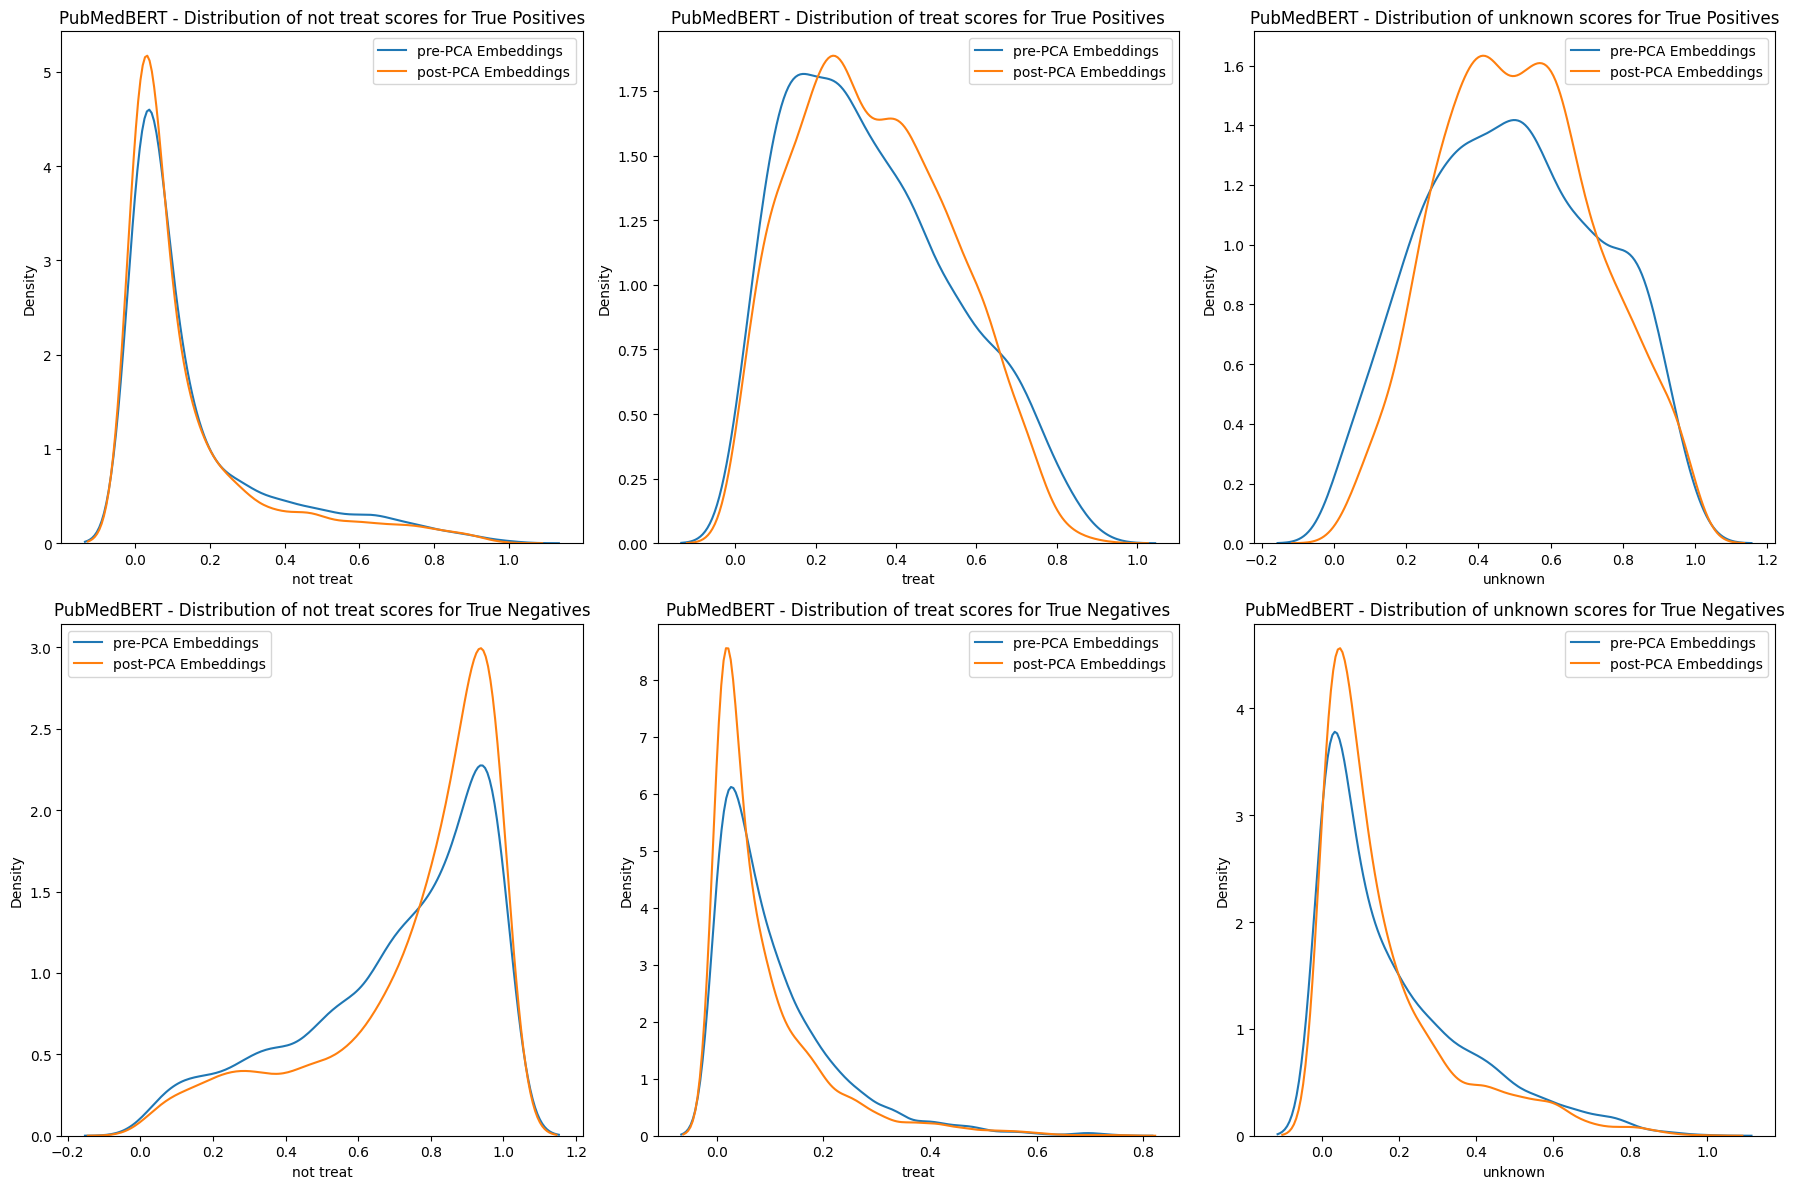

In [242]:
pubmed_df_full_1.columns=['not treat','treat', 'unknown']
pubmed_df_full_pca_1.columns=['not treat','treat', 'unknown']

pubmed_df_full_1['GT']=test.y
pubmed_df_full_pca_1['GT']=test.y

def plot_kde(ax, data, column, gt, title):
    sns.kdeplot(data=data.loc[data.GT==gt], x=column, ax=ax, label='pre-PCA Embeddings')
    sns.kdeplot(data=pubmed_df_full_pca_1.loc[pubmed_df_full_pca_1.GT==gt], x=column, ax=ax, label='post-PCA Embeddings')
    ax.set_title(title)
    ax.legend()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

plot_kde(axes[0, 0], pubmed_df_full_1, 'not treat', 1, 'PubMedBERT - Distribution of not treat scores for True Positives')
plot_kde(axes[0, 1], pubmed_df_full_1, 'treat', 1, 'PubMedBERT - Distribution of treat scores for True Positives')
plot_kde(axes[0, 2], pubmed_df_full_1, 'unknown', 1, 'PubMedBERT - Distribution of unknown scores for True Positives')

plot_kde(axes[1, 0], pubmed_df_full_1, 'not treat', 0, 'PubMedBERT - Distribution of not treat scores for True Negatives')
plot_kde(axes[1, 1], pubmed_df_full_1, 'treat', 0, 'PubMedBERT - Distribution of treat scores for True Negatives')
plot_kde(axes[1, 2], pubmed_df_full_1, 'unknown', 0, 'PubMedBERT - Distribution of unknown scores for True Negatives')

plt.tight_layout()
plt.show()

In [243]:
multi_index = pd.MultiIndex.from_arrays([['openai_full', 'openai_full', 'openai_full'],['not treat','treat','unknown']])
openai_df_full_1.columns = multi_index

multi_index = pd.MultiIndex.from_arrays([['openai_pca', 'openai_pca', 'openai_pca'],['not treat','treat','unknown']])
openai_df_full_pca_1.columns = multi_index

pd.concat([openai_df_full_1, openai_df_full_pca_1], axis=1)

openai_full                     openai_pca                    
       not treat     treat   unknown  not treat     treat   unknown
0       0.838094  0.012893  0.149013   0.968259  0.004215  0.027526
1       0.132875  0.475239  0.391887   0.196416  0.407204  0.396380
2       0.785355  0.029391  0.185254   0.944848  0.005484  0.049669
3       0.984881  0.004791  0.010328   0.990759  0.001061  0.008180
4       0.444666  0.194694  0.360639   0.582352  0.144675  0.272973
...          ...       ...       ...        ...       ...       ...
5458    0.195879  0.276766  0.527355   0.131768  0.438028  0.430204
5459    0.816770  0.053965  0.129266   0.815622  0.020668  0.163710
5460    0.954698  0.023397  0.021905   0.963987  0.009705  0.026308
5461    0.949466  0.028325  0.022209   0.944134  0.030150  0.025716
5462    0.167932  0.503467  0.328601   0.102555  0.555085  0.342359

[5463 rows x 6 columns]

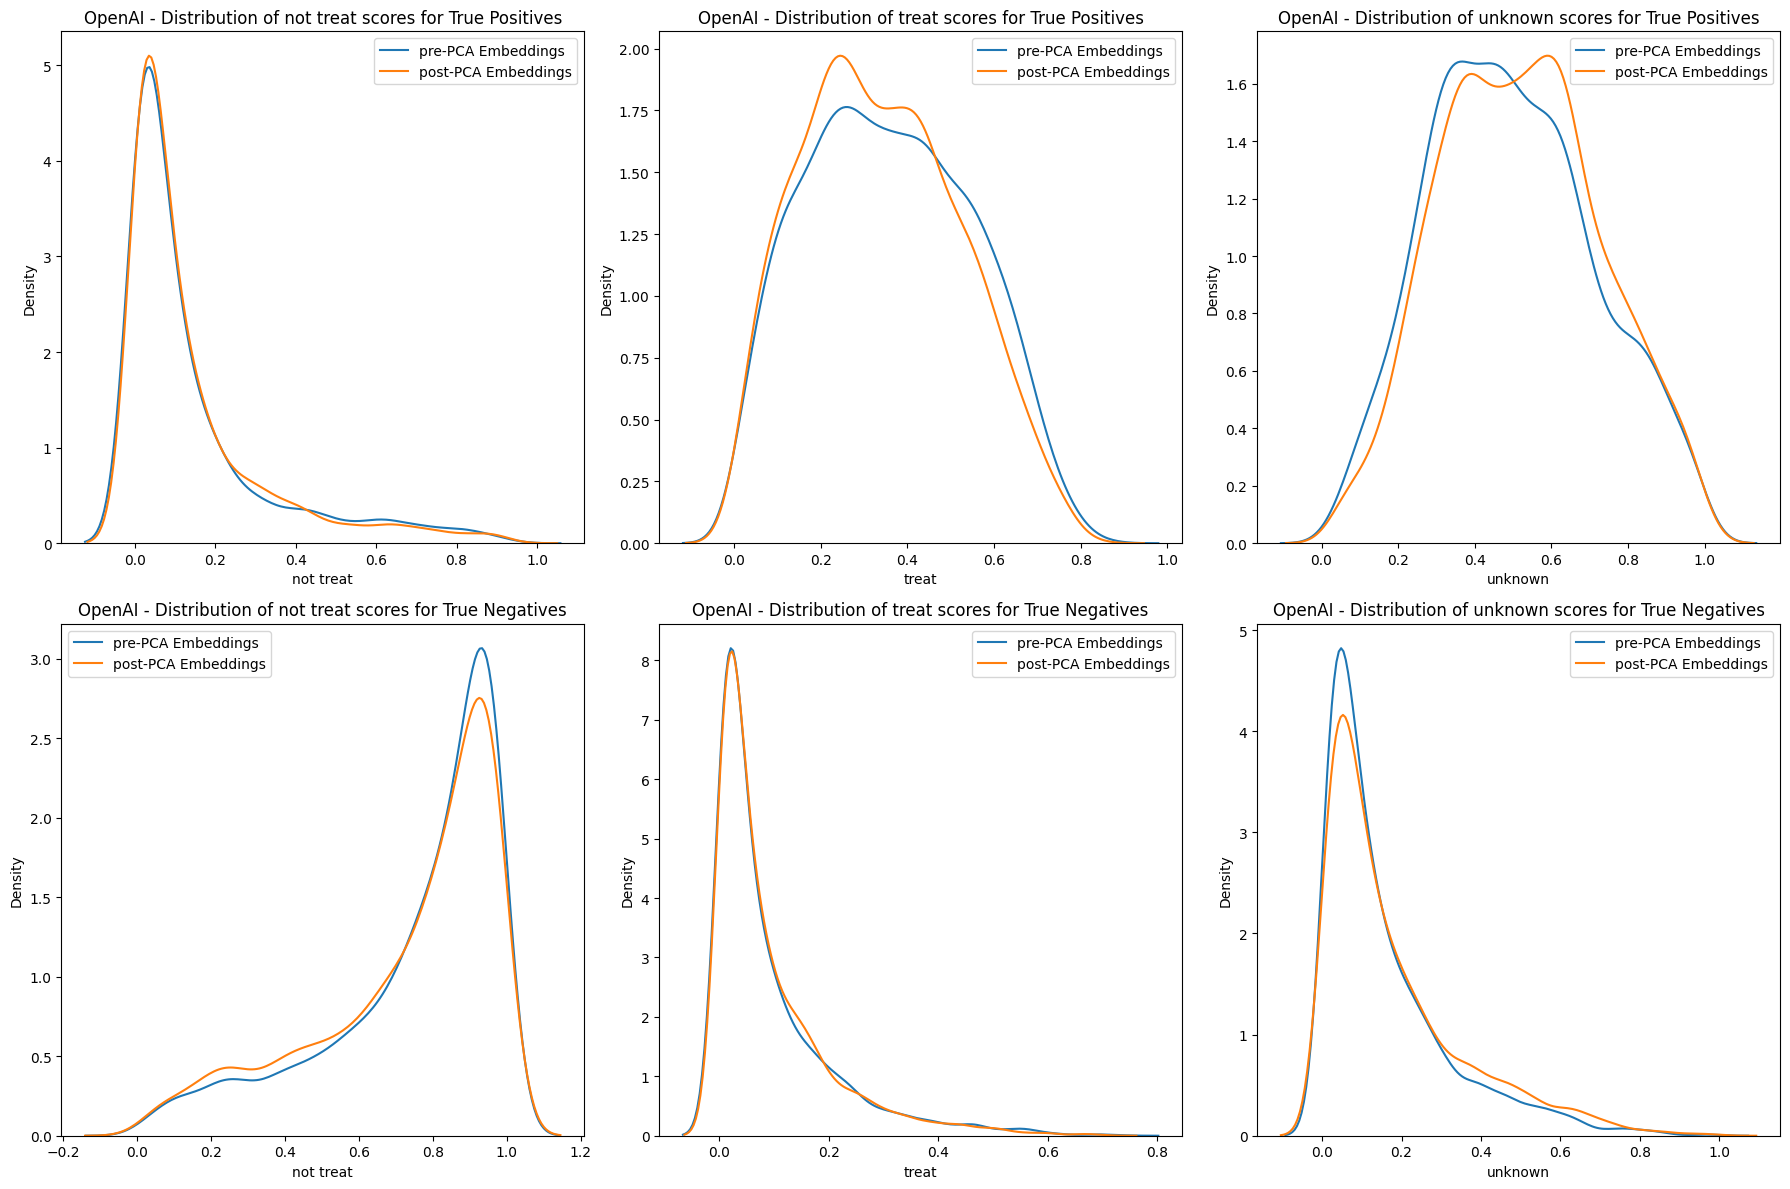

In [244]:
openai_df_full_1.columns=['not treat','treat', 'unknown']
openai_df_full_pca_1.columns=['not treat','treat', 'unknown']


openai_df_full_1['GT']=test.y
openai_df_full_pca_1['GT']=test.y

def plot_kde(ax, data, column, gt, title):
    sns.kdeplot(data=data.loc[data.GT==gt], x=column, ax=ax, label='pre-PCA Embeddings')
    sns.kdeplot(data=openai_df_full_pca_1.loc[openai_df_full_pca_1.GT==gt], x=column, ax=ax, label='post-PCA Embeddings')
    ax.set_title(title)
    ax.legend()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

plot_kde(axes[0, 0], openai_df_full_1, 'not treat', 1, 'OpenAI - Distribution of not treat scores for True Positives')
plot_kde(axes[0, 1], openai_df_full_1, 'treat', 1, 'OpenAI - Distribution of treat scores for True Positives')
plot_kde(axes[0, 2], openai_df_full_1, 'unknown', 1, 'OpenAI - Distribution of unknown scores for True Positives')

plot_kde(axes[1, 0], openai_df_full_1, 'not treat', 0, 'OpenAI - Distribution of not treat scores for True Negatives')
plot_kde(axes[1, 1], openai_df_full_1, 'treat', 0, 'OpenAI - Distribution of treat scores for True Negatives')
plot_kde(axes[1, 2], openai_df_full_1, 'unknown', 0, 'OpenAI - Distribution of unknown scores for True Negatives')

plt.tight_layout()
plt.show()

In [251]:
multi_index = pd.MultiIndex.from_arrays([['spacy_full', 'spacy_full', 'spacy_full'],['not treat','treat','unknown']])
spacy_df_full_1.columns = multi_index

multi_index = pd.MultiIndex.from_arrays([['spacy_pca', 'spacy_pca', 'spacy_pca'],['not treat','treat','unknown']])
spacy_df_full_pca_xgb_1.columns = multi_index


pd.concat([spacy_df_full_1, spacy_df_full_pca_xgb_1], axis=1)

spacy_full                     spacy_pca                    
      not treat     treat   unknown not treat     treat   unknown
0      0.995863  0.001238  0.002898  0.985056  0.001053  0.013891
1      0.582100  0.170642  0.247258  0.581311  0.177141  0.241548
2      0.308061  0.133112  0.558827  0.274676  0.149597  0.575727
3      0.874282  0.022689  0.103029  0.897111  0.012004  0.090885
4      0.582100  0.170642  0.247258  0.581311  0.177141  0.241548
...         ...       ...       ...       ...       ...       ...
5458   0.477285  0.213527  0.309189  0.471538  0.216532  0.311930
5459   0.948477  0.015292  0.036231  0.935204  0.042145  0.022651
5460   0.218080  0.123294  0.658626  0.219742  0.126168  0.654089
5461   0.195340  0.113163  0.691497  0.617345  0.051062  0.331592
5462   0.066002  0.565685  0.368313  0.047296  0.615365  0.337338

[5463 rows x 6 columns]

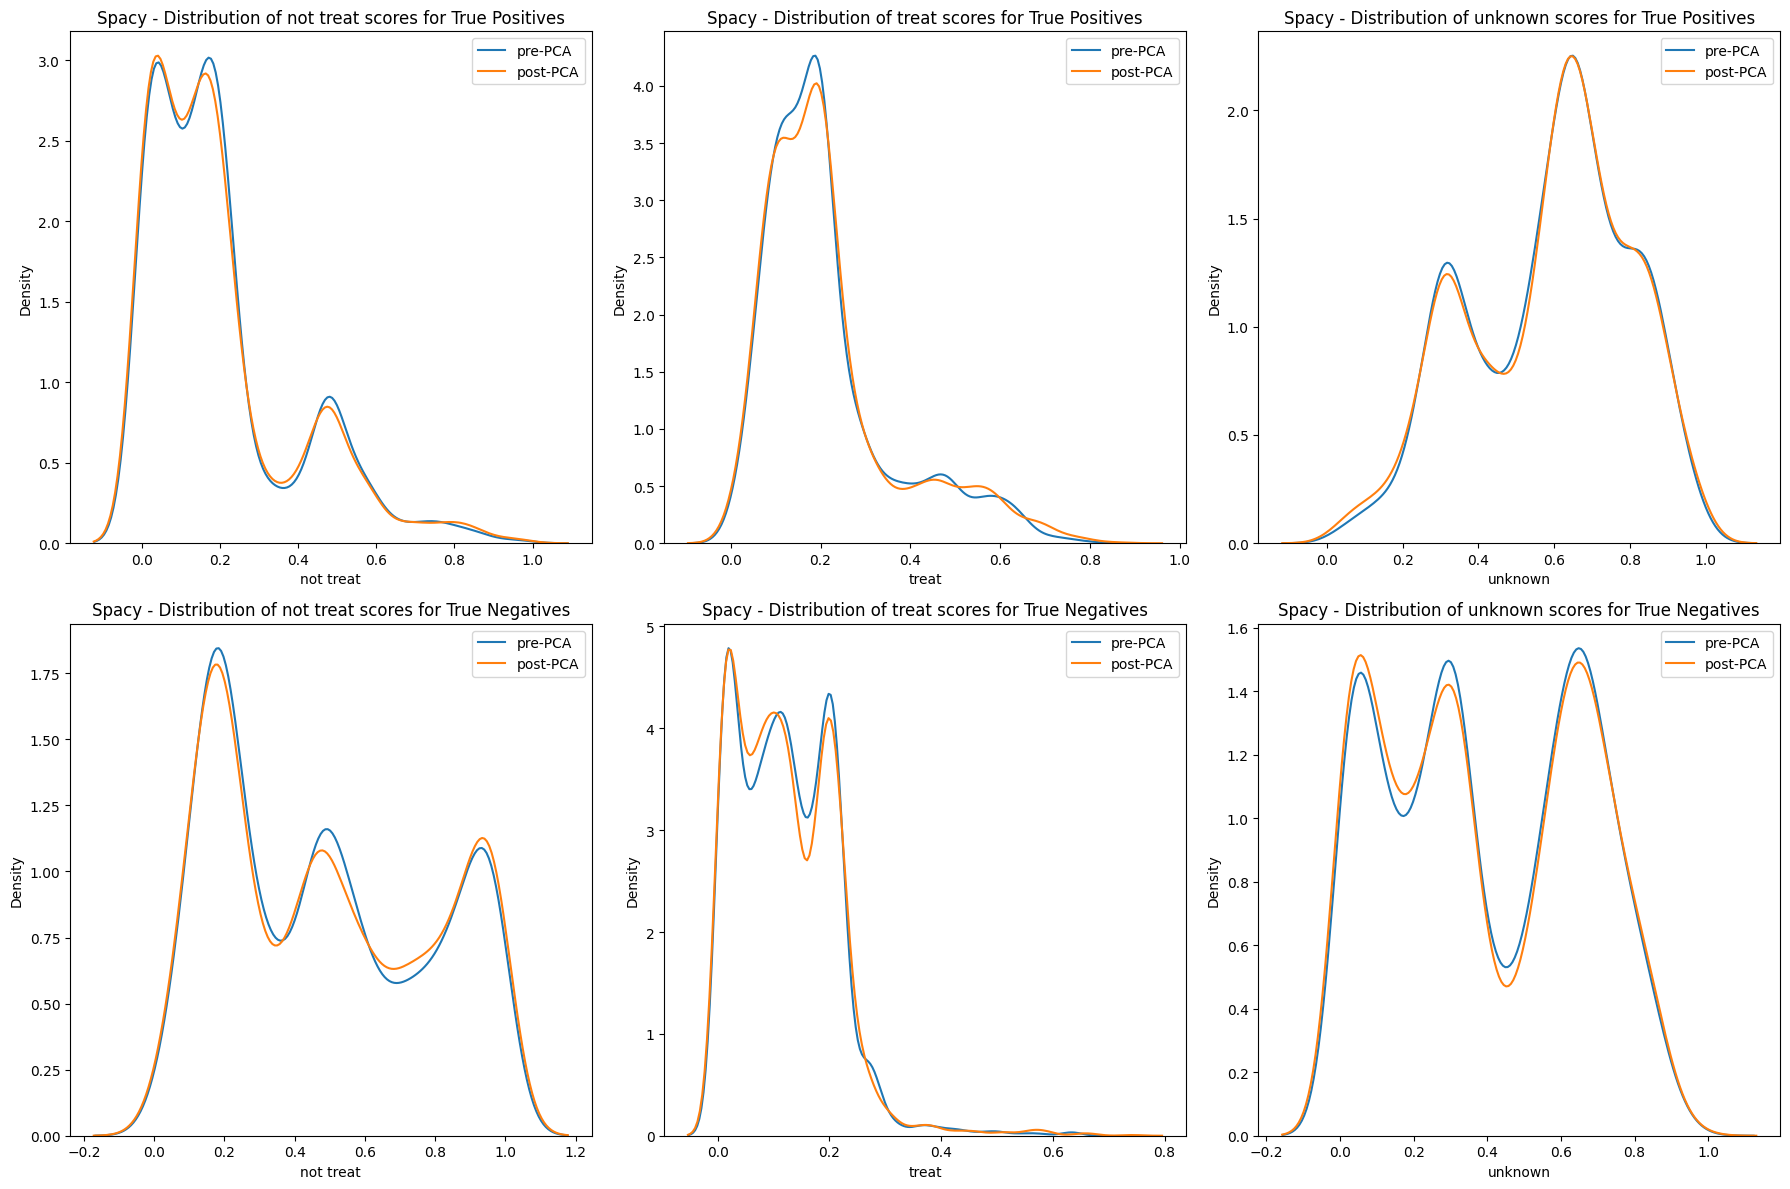

In [252]:
import seaborn as sns
import matplotlib.pyplot as plt

spacy_df_full_1.columns=['not treat','treat', 'unknown']
spacy_df_full_pca_1.columns=['not treat','treat', 'unknown']

spacy_df_full_1['GT']=test.y
spacy_df_full_pca_1['GT']=test.y

# Define a function to plot KDEs
def plot_kde(ax, data, column, gt, title):
    sns.kdeplot(data=data.loc[data.GT==gt], x=column, ax=ax, label='pre-PCA')
    sns.kdeplot(data=spacy_df_full_pca_1.loc[spacy_df_full_pca_1.GT==gt], x=column, ax=ax, label='post-PCA')
    ax.set_title(title)
    ax.legend()

# Create a 2x3 grid for subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot True Positives
plot_kde(axes[0, 0], spacy_df_full_1, 'not treat', 1, 'Spacy - Distribution of not treat scores for True Positives')
plot_kde(axes[0, 1], spacy_df_full_1, 'treat', 1, 'Spacy - Distribution of treat scores for True Positives')
plot_kde(axes[0, 2], spacy_df_full_1, 'unknown', 1, 'Spacy - Distribution of unknown scores for True Positives')

# Plot True Negatives
plot_kde(axes[1, 0], spacy_df_full_1, 'not treat', 0, 'Spacy - Distribution of not treat scores for True Negatives')
plot_kde(axes[1, 1], spacy_df_full_1, 'treat', 0, 'Spacy - Distribution of treat scores for True Negatives')
plot_kde(axes[1, 2], spacy_df_full_1, 'unknown', 0, 'Spacy - Distribution of unknown scores for True Negatives')

# Adjust layout
plt.tight_layout()
plt.show()

In [256]:
multi_index = pd.MultiIndex.from_arrays([['scispacy_full', 'scispacy_full', 'scispacy_full'],['not treat','treat','unknown']])
scispacy_df_full_1.columns = multi_index

multi_index = pd.MultiIndex.from_arrays([['scispacy_pca', 'scispacy_pca', 'scispacy_pca'],['not treat','treat','unknown']])
scispacy_df_full_pca_1.columns = multi_index

pd.concat([scispacy_df_full_1, scispacy_df_full_pca_1], axis=1)

scispacy_full                     scispacy_pca                    
         not treat     treat   unknown    not treat     treat   unknown
0         0.944286  0.021429  0.034286     0.006340  0.022006  0.971654
1         0.484598  0.173138  0.342264     0.033323  0.020885  0.945791
2         0.464014  0.000000  0.535986     0.027598  0.012831  0.959571
3         0.415850  0.091469  0.492681     0.015447  0.022168  0.962385
4         0.565802  0.000000  0.434198     0.027073  0.024261  0.948666
...            ...       ...       ...          ...       ...       ...
5458      0.523764  0.273463  0.202773     0.025307  0.015207  0.959486
5459      1.000000  0.000000  0.000000     0.019692  0.017723  0.962585
5460      0.429157  0.070134  0.500708     0.011517  0.019168  0.969316
5461      0.224596  0.091652  0.683752     0.022765  0.022875  0.954360
5462      0.149992  0.507937  0.342071     0.006867  0.027671  0.965462

[5463 rows x 6 columns]

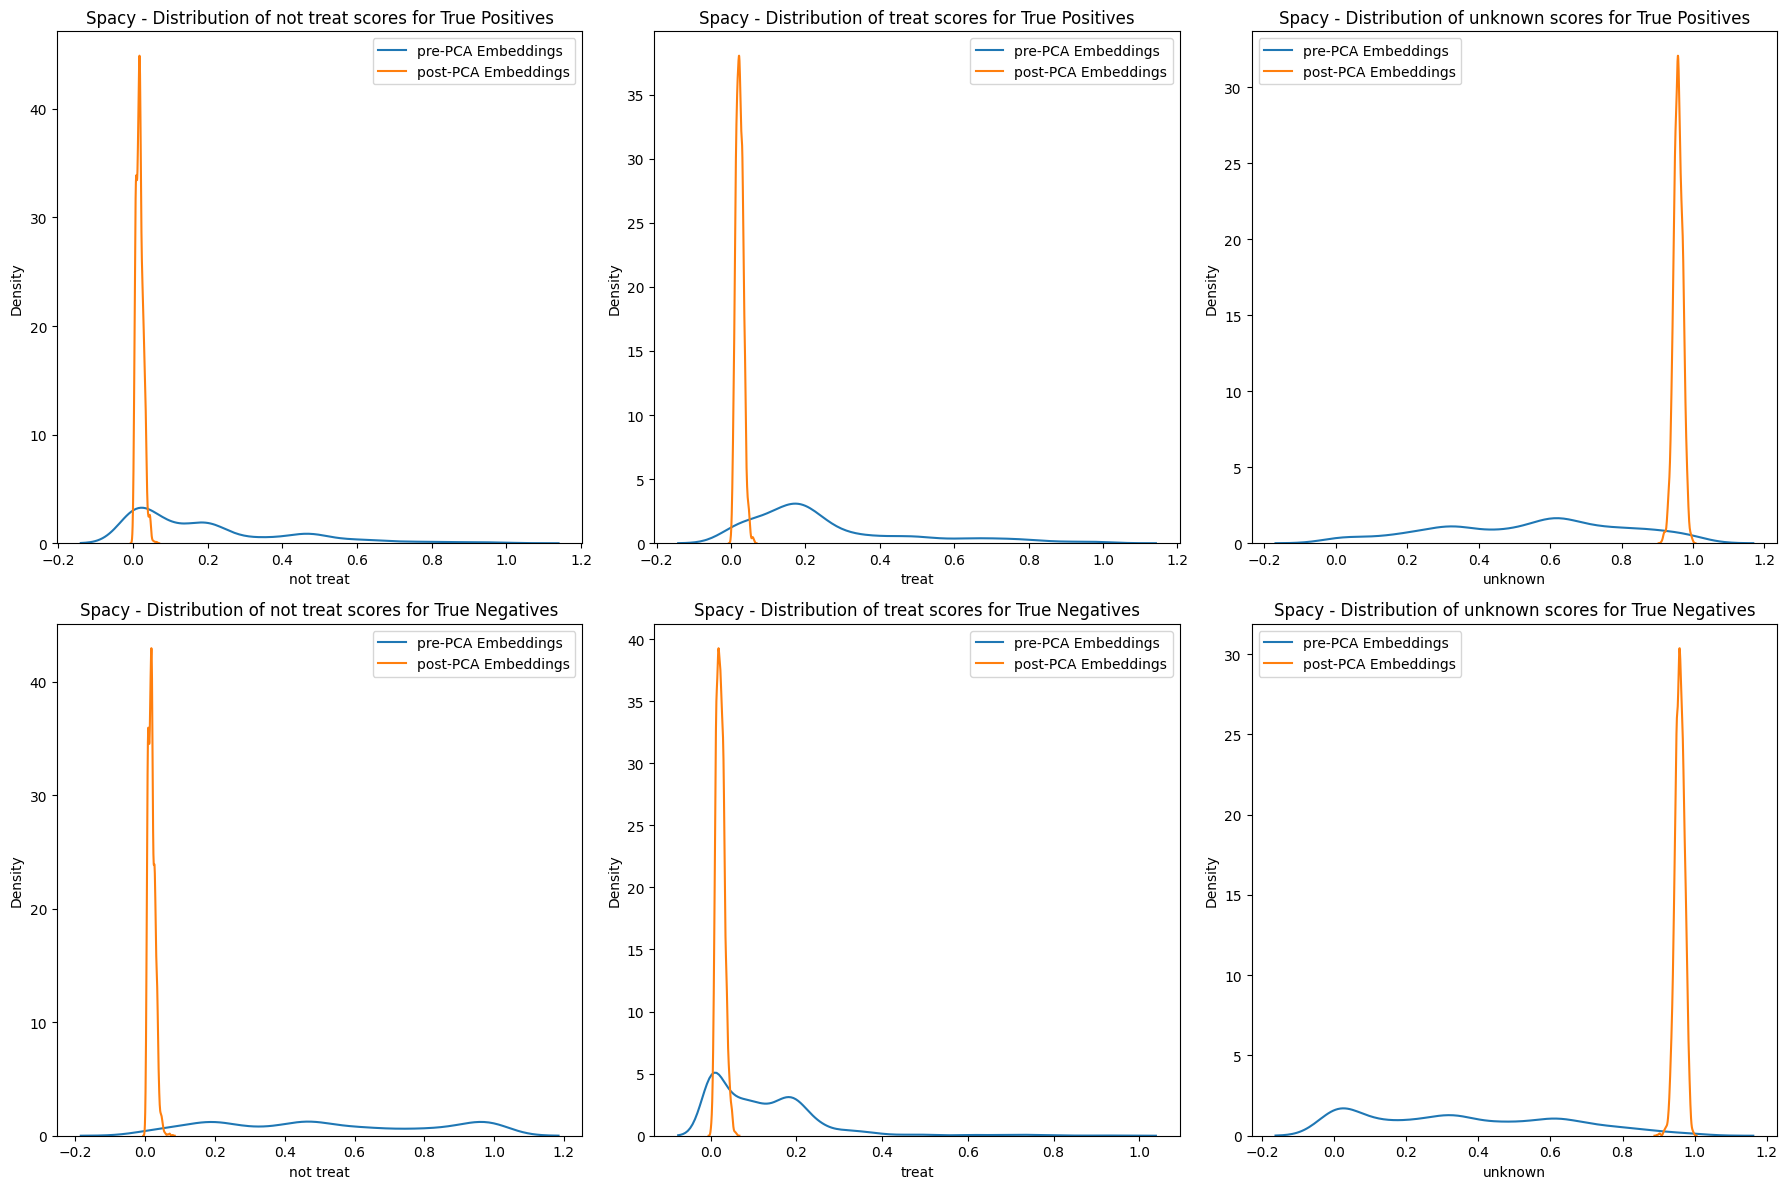

In [259]:
scispacy_df_full_1.columns=['not treat','treat', 'unknown']
scispacy_df_full_pca_1.columns=['not treat','treat', 'unknown']

scispacy_df_full_1['GT']=test.y
scispacy_df_full_pca_1['GT']=test.y

# Define a function to plot KDEs
def plot_kde(ax, data, column, gt, title):
    sns.kdeplot(data=data.loc[data.GT==gt], x=column, ax=ax, label='pre-PCA Embeddings')
    sns.kdeplot(data=scispacy_df_full_pca_1.loc[scispacy_df_full_pca_1.GT==gt], x=column, ax=ax, label='post-PCA Embeddings')
    ax.set_title(title)
    ax.legend()

# Create a 2x3 grid for subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot True Positives
plot_kde(axes[0, 0], scispacy_df_full_1, 'not treat', 1, 'Spacy - Distribution of not treat scores for True Positives')
plot_kde(axes[0, 1], scispacy_df_full_1, 'treat', 1, 'Spacy - Distribution of treat scores for True Positives')
plot_kde(axes[0, 2], scispacy_df_full_1, 'unknown', 1, 'Spacy - Distribution of unknown scores for True Positives')

# Plot True Negatives
plot_kde(axes[1, 0], scispacy_df_full_1, 'not treat', 0, 'Spacy - Distribution of not treat scores for True Negatives')
plot_kde(axes[1, 1], scispacy_df_full_1, 'treat', 0, 'Spacy - Distribution of treat scores for True Negatives')
plot_kde(axes[1, 2], scispacy_df_full_1, 'unknown', 0, 'Spacy - Distribution of unknown scores for True Negatives')

# Adjust layout
plt.tight_layout()
plt.show()

The distribution of scores for PubMedBERT and OpenAI is aligned with the ground truth scores (i.e. for True Negatives, we can see not treat score peaking close to 1 and treat score peaking closer to 0; for True Positive scores we can see not treat score peaking close to 0 and treat scores being more uniformly distributed). This is a sign of data leakage. Other than that, PubMedBERT and OpenAI distribution scores are quite similar.
Also:
* PCA transformation doesn't impact the distirbution scores much
* Spacy distributions show moderately bad quality of embeddings
* Scispacy distributions show really bad quality of embeddings

## Test no.2 (cloxotestosterone - prostate carcinoma) 
Repeating with test set no 2 (as per v1 notebook)

In [ ]:
#re-load embeddings as we previously overwrote them

#pubmedbert
pubmed_emb = np.array(joblib.load('scratch/pubmedbert_embed_full.joblib'))

# #openai
openai_emb = np.array(joblib.load('scratch/openai_full_embed.joblib'))

# #spacy
spacy_emb = np.array(joblib.load('scratch/en_core_web_md_spacy_embed_full.joblib'))

# #scispacy
scispacy_emb = np.array(joblib.load('scratch/en_core_sci_md_scispacy_embed_full.joblib'))


In [260]:
#create sub-dfs
DRUG_TYPE = ['biolink:Drug', 'biolink:SmallMolecule']
DISEASE_TYPE = ['biolink:Disease', 'biolink:PhenotypicFeature', 'biolink:BehavioralFeature', 'biolink:DiseaseOrPhenotypicFeature']

#sample
sample_df_drugs = sample_df[sample_df['category'].isin(DRUG_TYPE)]
sample_df_disease = sample_df[sample_df['category'].isin(DISEASE_TYPE)]

#train test split 
train, test = train_test_split(gt, stratify=gt['y'], test_size=0.1, random_state=2)
train_tp_df = train[train['y']==1]
train_tp_df_drugs = train_tp_df['source'].reset_index(drop=True)
train_tp_df_diseases = train_tp_df['target'].reset_index(drop=True)
len_tp_tr = len(train_tp_df)
n_rep = 3

# create random drug-disease pairs
rand_drugs = sample_df_drugs['id'].sample(n_rep*len_tp_tr, replace=True, ignore_index = True, random_state = 2) # 42
rand_disease = sample_df_disease['id'].sample(n_rep*len_tp_tr, replace=True, ignore_index = True, random_state = 2) # 42
train_tp_diseases_copies = pd.concat([train_tp_df_diseases for _ in range(n_rep)], ignore_index = True)
train_tp_drugs_copies = pd.concat([train_tp_df_drugs for _ in range(n_rep)], ignore_index = True)
tmp_1 = pd.DataFrame({'source': rand_drugs, 'target': train_tp_diseases_copies, 'y': 2})
tmp_2 = pd.DataFrame({'source': train_tp_drugs_copies, 'target': rand_disease, 'y': 2})
un_data_1 =  pd.concat([tmp_1,tmp_2], ignore_index =True)
train_df_1 = pd.concat([train, un_data_1]).sample(frac=1).reset_index(drop=True)
test = test.reset_index(drop=True)

### Model predictions - full embeddings (node:name + node:category embedded)

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

feature_length = 1536

# Precompute lookup dictionaries
drug_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}
disease_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}

X_pubmed = np.empty((len(train_df_1), feature_length), dtype='float32')
drug_indices = train_df_1['source'].map(drug_id_dict)
disease_indices = train_df_1['target'].map(disease_id_dict)

for index in tqdm(range(len(train_df_1))):
    drug_vector = pubmed_emb[drug_indices.iloc[index]]
    disease_vector = pubmed_emb[disease_indices.iloc[index]]
    X_pubmed[index] = np.concatenate([drug_vector, disease_vector])

y_pubmed = train_df_1.y.to_numpy()

# For the test dataset
test = test.reset_index(drop=True)
X_pubmed_test = np.empty((len(test), feature_length), dtype='float32')

test_drug_indices = test['source'].map(drug_id_dict)
test_disease_indices = test['target'].map(disease_id_dict)

for index in tqdm(range(len(test))):
    drug_vector = pubmed_emb[test_drug_indices.iloc[index]]
    disease_vector = pubmed_emb[test_disease_indices.iloc[index]]
    X_pubmed_test[index] = np.concatenate([drug_vector, disease_vector])

y_pubmed_test = test.y.to_numpy()

In [ ]:
# xgboost
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_pubmed, y_pubmed)

y_pubmed_pred = xgb.predict_proba(X_pubmed_test)
y_pubmed_proba = xgb.predict_proba(X_pubmed_test)

print('xgboost scores (not treat; treat; unknown)')
print(y_pubmed_proba)

pubmed_df_full_xgb_2 = pd.DataFrame(y_pubmed_proba)
pubmed_df_full_xgb_2.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
pubmed_df_full_xgb_2.to_csv('scratch/pubmed_df_full_xgb_2.csv')

# random forest
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_pubmed, y_pubmed)

y_pubmed_pred = rf_clf.predict_proba(X_pubmed_test)
y_pubmed_proba = rf_clf.predict_proba(X_pubmed_test)

print('random forest scores (not treat; treat; unknown)')
print(y_pubmed_proba)

pubmed_df_full_rf_2 = pd.DataFrame(y_pubmed_proba)
pubmed_df_full_rf_2.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
pubmed_df_full_rf_2.to_csv('scratch/pubmed_df_full_rf_2.csv')


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

feature_length = 1536

# Precompute lookup dictionaries
drug_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}
disease_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}

X_openai = np.empty((len(train_df_1), feature_length), dtype='float32')
drug_indices = train_df_1['source'].map(drug_id_dict)
disease_indices = train_df_1['target'].map(disease_id_dict)

for index in tqdm(range(len(train_df_1))):
    drug_vector = openai_emb[drug_indices.iloc[index]]
    disease_vector = openai_emb[disease_indices.iloc[index]]
    X_openai[index] = np.concatenate([drug_vector, disease_vector])

y_openai = train_df_1.y.to_numpy()

# For the test dataset
test = test.reset_index(drop=True)
X_openai_test = np.empty((len(test), feature_length), dtype='float32')

test_drug_indices = test['source'].map(drug_id_dict)
test_disease_indices = test['target'].map(disease_id_dict)

for index in tqdm(range(len(test))):
    drug_vector = openai_emb[test_drug_indices.iloc[index]]
    disease_vector = openai_emb[test_disease_indices.iloc[index]]
    X_openai_test[index] = np.concatenate([drug_vector, disease_vector])

y_openai_test = test.y.to_numpy()

In [ ]:
# xgboost
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_openai, y_openai)

y_openai_pred = xgb.predict_proba(X_openai_test)
y_openai_proba = xgb.predict_proba(X_openai_test)

print('xgboost scores (not treat; treat; unknown)')
print(y_openai_proba)

openai_df_full_2 = pd.DataFrame(y_openai_proba)
openai_df_full_2.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']

openai_df_full_xgb_2 = pd.DataFrame(y_openai_proba)
openai_df_full_xgb_2.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
openai_df_full_xgb_2.to_csv('scratch/openai_df_full_xgb_2.csv')

# random forest
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_openai, y_openai)

y_openai_pred = rf_clf.predict_proba(X_openai_test)
y_openai_proba = rf_clf.predict_proba(X_openai_test)

print('random forest scores (not treat; treat; unknown)')
print(y_openai_proba)

openai_df_full_rf_2 = pd.DataFrame(y_openai_proba)
openai_df_full_rf_2.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
openai_df_full_rf_2.to_csv('scratch/openai_df_full_rf_2.csv')

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

feature_length = 600

# Precompute lookup dictionaries
drug_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}
disease_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}

X_spacy = np.empty((len(train_df_1), feature_length), dtype='float32')
drug_indices = train_df_1['source'].map(drug_id_dict)
disease_indices = train_df_1['target'].map(disease_id_dict)

for index in tqdm(range(len(train_df_1))):
    drug_vector = spacy_emb[drug_indices.iloc[index]]
    disease_vector = spacy_emb[disease_indices.iloc[index]]
    X_spacy[index] = np.concatenate([drug_vector, disease_vector])

y_spacy = train_df_1.y.to_numpy()

# For the test dataset
test = test.reset_index(drop=True)
X_spacy_test = np.empty((len(test), feature_length), dtype='float32')

test_drug_indices = test['source'].map(drug_id_dict)
test_disease_indices = test['target'].map(disease_id_dict)

for index in tqdm(range(len(test))):
    drug_vector = spacy_emb[test_drug_indices.iloc[index]]
    disease_vector = spacy_emb[test_disease_indices.iloc[index]]
    X_spacy_test[index] = np.concatenate([drug_vector, disease_vector])

y_spacy_test = test.y.to_numpy()

In [ ]:
# xgboost
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_spacy, y_spacy)

y_spacy_pred = xgb.predict_proba(X_spacy_test)
y_spacy_proba = xgb.predict_proba(X_spacy_test)

print('xgboost scores (not treat; treat; unknown)')
print(y_spacy_proba)

spacy_df_full_xgb_2 = pd.DataFrame(y_spacy_proba)
spacy_df_full_xgb_2.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
spacy_df_full_xgb_2.to_csv('scratch/spacy_df_full_xgb_2.csv')

# random forest
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_spacy, y_spacy)

y_spacy_pred = rf_clf.predict_proba(X_spacy_test)
y_spacy_proba = rf_clf.predict_proba(X_spacy_test)

print('random forest scores (not treat; treat; unknown)')
print(y_spacy_proba)

spacy_df_full_rf_2 = pd.DataFrame(y_spacy_proba)
spacy_df_full_rf_2.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
spacy_df_full_rf_2.to_csv('scratch/spacy_df_full_rf_2.csv')

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

feature_length = 400

# Precompute lookup dictionaries
drug_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}
disease_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}

X_scispacy = np.empty((len(train_df_1), feature_length), dtype='float32')
drug_indices = train_df_1['source'].map(drug_id_dict)
disease_indices = train_df_1['target'].map(disease_id_dict)

for index in tqdm(range(len(train_df_1))):
    drug_vector = scispacy_emb[drug_indices.iloc[index]]
    disease_vector = scispacy_emb[disease_indices.iloc[index]]
    X_scispacy[index] = np.concatenate([drug_vector, disease_vector])

y_scispacy = train_df_1.y.to_numpy()

# For the test dataset
test = test.reset_index(drop=True)
X_scispacy_test = np.empty((len(test), feature_length), dtype='float32')

test_drug_indices = test['source'].map(drug_id_dict)
test_disease_indices = test['target'].map(disease_id_dict)

for index in tqdm(range(len(test))):
    drug_vector = scispacy_emb[test_drug_indices.iloc[index]]
    disease_vector = scispacy_emb[test_disease_indices.iloc[index]]
    X_scispacy_test[index] = np.concatenate([drug_vector, disease_vector])

y_scispacy_test = test.y.to_numpy()

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
# xgboost
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_scispacy, y_scispacy)

y_scispacy_pred = xgb.predict_proba(X_scispacy_test)
y_scispacy_proba = xgb.predict_proba(X_scispacy_test)

print('xgboost scores (not treat; treat; unknown)')
print(y_scispacy_proba)

scispacy_df_full_xgb_2 = pd.DataFrame(y_scispacy_proba)
scispacy_df_full_xgb_2.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
scispacy_df_full_xgb_2.to_csv('scratch/scispacy_df_full_rf_2.csv')

# random forest
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_scispacy, y_scispacy)

y_scispacy_pred = rf_clf.predict_proba(X_scispacy_test)
y_scispacy_proba = rf_clf.predict_proba(X_scispacy_test)

print('random forest scores (not treat; treat; unknown)')
print(y_scispacy_proba)

scispacy_df_full_rf_2 = pd.DataFrame(y_scispacy_proba)
scispacy_df_full_rf_2.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
scispacy_df_full_rf_2.to_csv('scratch/scispacy_df_full_rf_2.csv')

### Model predictions - post-PCA full embeddings (node:name + node:category embedded)

In [ ]:
# for convenience we overwrite the emb, this way we just copy paste the results
# can be automated 
pubmed_emb = pubmed_emb_pca 
openai_emb = openai_emb_pca
scispacy_emb = scispacy_emb_pca
spacy_emb = spacy_emb_pca

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

feature_length = 200

# Precompute lookup dictionaries
drug_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}
disease_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}

X_pubmed = np.empty((len(train_df_1), feature_length), dtype='float32')
drug_indices = train_df_1['source'].map(drug_id_dict)
disease_indices = train_df_1['target'].map(disease_id_dict)

for index in tqdm(range(len(train_df_1))):
    drug_vector = pubmed_emb[drug_indices.iloc[index]]
    disease_vector = pubmed_emb[disease_indices.iloc[index]]
    X_pubmed[index] = np.concatenate([drug_vector, disease_vector])

y_pubmed = train_df_1.y.to_numpy()

# For the test dataset
test = test.reset_index(drop=True)
X_pubmed_test = np.empty((len(test), feature_length), dtype='float32')

test_drug_indices = test['source'].map(drug_id_dict)
test_disease_indices = test['target'].map(disease_id_dict)

for index in tqdm(range(len(test))):
    drug_vector = pubmed_emb[test_drug_indices.iloc[index]]
    disease_vector = pubmed_emb[test_disease_indices.iloc[index]]
    X_pubmed_test[index] = np.concatenate([drug_vector, disease_vector])

y_pubmed_test = test.y.to_numpy()

In [ ]:
# xgboost
xgb = XGBClassifier(random_state = 15)
xgb.fit(X_pubmed, y_pubmed)

y_pubmed_pred = xgb.predict_proba(X_pubmed_test)
y_pubmed_proba = xgb.predict_proba(X_pubmed_test)

print('xgboost scores (not treat; treat; unknown)')
print(y_pubmed_proba)

pubmed_df_full_pca_2 = pd.DataFrame(y_pubmed_proba)
pubmed_df_full_pca_2.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']

pubmed_df_full_pca_xgb_2 = pd.DataFrame(y_pubmed_proba)
pubmed_df_full_pca_xgb_2.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
pubmed_df_full_pca_xgb_2.to_csv('scratch/pubmed_df_pca_xgb_2.csv')

# random forest
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_pubmed, y_pubmed)

y_pubmed_pred = rf_clf.predict_proba(X_pubmed_test)
y_pubmed_proba = rf_clf.predict_proba(X_pubmed_test)

print('random forest scores (not treat; treat; unknown)')
print(y_pubmed_proba)

pubmed_df_full_rf_2 = pd.DataFrame(y_pubmed_proba)
pubmed_df_full_rf_2.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
pubmed_df_full_rf_2.to_csv('scratch/pubmed_df_pca_rf_2.csv')


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

feature_length = 200

# Precompute lookup dictionaries
drug_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}
disease_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}

X_openai = np.empty((len(train_df_1), feature_length), dtype='float32')
drug_indices = train_df_1['source'].map(drug_id_dict)
disease_indices = train_df_1['target'].map(disease_id_dict)

for index in tqdm(range(len(train_df_1))):
    drug_vector = openai_emb[drug_indices.iloc[index]]
    disease_vector = openai_emb[disease_indices.iloc[index]]
    X_openai[index] = np.concatenate([drug_vector, disease_vector])

y_openai = train_df_1.y.to_numpy()

# For the test dataset
test = test.reset_index(drop=True)
X_openai_test = np.empty((len(test), feature_length), dtype='float32')

test_drug_indices = test['source'].map(drug_id_dict)
test_disease_indices = test['target'].map(disease_id_dict)

for index in tqdm(range(len(test))):
    drug_vector = openai_emb[test_drug_indices.iloc[index]]
    disease_vector = openai_emb[test_disease_indices.iloc[index]]
    X_openai_test[index] = np.concatenate([drug_vector, disease_vector])

y_openai_test = test.y.to_numpy()

In [ ]:
# xgboost
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_openai, y_openai)

y_openai_pred = xgb.predict_proba(X_openai_test)
y_openai_proba = xgb.predict_proba(X_openai_test)

print('xgboost scores (not treat; treat; unknown)')
print(y_openai_proba)

openai_df_full_pca_xgb_2 = pd.DataFrame(y_openai_proba)
openai_df_full_pca_xgb_2.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
openai_df_full_pca_xgb_2.to_csv('scratch/openai_df_pca_xgb_2.csv')

# random forest
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_openai, y_openai)

y_openai_pred = rf_clf.predict_proba(X_openai_test)
y_openai_proba = rf_clf.predict_proba(X_openai_test)

print('random forest scores (not treat; treat; unknown)')
print(y_openai_proba)

openai_df_full_rf_2 = pd.DataFrame(y_openai_proba)
openai_df_full_rf_2.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
openai_df_full_rf_2.to_csv('scratch/openai_df_pca_rf_2.csv')

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

feature_length = 200

# Precompute lookup dictionaries
drug_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}
disease_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}

X_spacy = np.empty((len(train_df_1), feature_length), dtype='float32')
drug_indices = train_df_1['source'].map(drug_id_dict)
disease_indices = train_df_1['target'].map(disease_id_dict)

for index in tqdm(range(len(train_df_1))):
    drug_vector = spacy_emb[drug_indices.iloc[index]]
    disease_vector = spacy_emb[disease_indices.iloc[index]]
    X_spacy[index] = np.concatenate([drug_vector, disease_vector])

y_spacy = train_df_1.y.to_numpy()

# For the test dataset
test = test.reset_index(drop=True)
X_spacy_test = np.empty((len(test), feature_length), dtype='float32')

test_drug_indices = test['source'].map(drug_id_dict)
test_disease_indices = test['target'].map(disease_id_dict)

for index in tqdm(range(len(test))):
    drug_vector = spacy_emb[test_drug_indices.iloc[index]]
    disease_vector = spacy_emb[test_disease_indices.iloc[index]]
    X_spacy_test[index] = np.concatenate([drug_vector, disease_vector])

y_spacy_test = test.y.to_numpy()

In [ ]:
# xgboost
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_spacy, y_spacy)

y_spacy_pred = xgb.predict_proba(X_spacy_test)
y_spacy_proba = xgb.predict_proba(X_spacy_test)

print('xgboost scores (not treat; treat; unknown)')
print(y_spacy_proba)

spacy_df_full_pca_xgb_2 = pd.DataFrame(y_spacy_proba)
spacy_df_full_pca_xgb_2.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
spacy_df_full_pca_xgb_2.to_csv('scratch/spacy_df_pca_xgb_2.csv')

# random forest
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_spacy, y_spacy)

y_spacy_pred = rf_clf.predict_proba(X_spacy_test)
y_spacy_proba = rf_clf.predict_proba(X_spacy_test)

print('random forest scores (not treat; treat; unknown)')
print(y_spacy_proba)

spacy_df_full_rf_2 = pd.DataFrame(y_spacy_proba)
spacy_df_full_rf_2.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
spacy_df_full_rf_2.to_csv('scratch/spacy_df_pca_rf_2.csv')

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

feature_length = 200

# Precompute lookup dictionaries
drug_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}
disease_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}

X_scispacy = np.empty((len(train_df_1), feature_length), dtype='float32')
drug_indices = train_df_1['source'].map(drug_id_dict)
disease_indices = train_df_1['target'].map(disease_id_dict)

for index in tqdm(range(len(train_df_1))):
    drug_vector = scispacy_emb[drug_indices.iloc[index]]
    disease_vector = scispacy_emb[disease_indices.iloc[index]]
    X_scispacy[index] = np.concatenate([drug_vector, disease_vector])

y_scispacy = train_df_1.y.to_numpy()

# For the test dataset
test = test.reset_index(drop=True)
X_scispacy_test = np.empty((len(test), feature_length), dtype='float32')

test_drug_indices = test['source'].map(drug_id_dict)
test_disease_indices = test['target'].map(disease_id_dict)

for index in tqdm(range(len(test))):
    drug_vector = scispacy_emb[test_drug_indices.iloc[index]]
    disease_vector = scispacy_emb[test_disease_indices.iloc[index]]
    X_scispacy_test[index] = np.concatenate([drug_vector, disease_vector])

y_scispacy_test = test.y.to_numpy()

In [ ]:
# xgboost
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_scispacy, y_scispacy)

y_scispacy_pred = xgb.predict_proba(X_scispacy_test)
y_scispacy_proba = xgb.predict_proba(X_scispacy_test)

print('xgboost scores (not treat; treat; unknown)')
print(y_scispacy_proba)

scispacy_df_full_pca_xgb_2 = pd.DataFrame(y_scispacy_proba)
scispacy_df_full_pca_xgb_2.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
scispacy_df_full_pca_xgb_2.to_csv('scratch/scispacy_df_pca_xgb_2.csv')

# random forest
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_spacy, y_spacy)

y_scispacy_pred = rf_clf.predict_proba(X_scispacy_test)
y_scispacy_proba = rf_clf.predict_proba(X_scispacy_test)

print('random forest scores (not treat; treat; unknown)')
print(y_scispacy_proba)

scispacy_df_full_rf_2 = pd.DataFrame(y_scispacy_proba)
scispacy_df_full_rf_2.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
scispacy_df_full_rf_2.to_csv('scratch/scispacy_df_pca_rf_2.csv')

### Summary - test data no.2

In [262]:
#load if needed

pubmed_df_full_2 = pd.read_csv('scratch/pubmed_df_full_xgb_2.csv', index_col=0)
pubmed_df_full_pca_2 = pd.read_csv('scratch/pubmed_df_pca_xgb_2.csv', index_col=0)

openai_df_full_2 = pd.read_csv('scratch/openai_df_full_xgb_2.csv', index_col=0)
openai_df_full_pca_2 = pd.read_csv('scratch/openai_df_pca_xgb_2.csv', index_col=0)

spacy_df_full_2 = pd.read_csv('scratch/spacy_df_full_xgb_2.csv', index_col=0)
spacy_df_full_pca_2 = pd.read_csv('scratch/spacy_df_pca_xgb_2.csv', index_col=0)

scispacy_df_full_2 = pd.read_csv('scratch/scispacy_df_full_rf_2.csv', index_col=0)
scispacy_df_full_pca_2 = pd.read_csv('scratch/scispacy_df_pca_rf_2.csv', index_col=0)

In [266]:
multi_index = pd.MultiIndex.from_arrays([['pubmed_full', 'pubmed_full', 'pubmed_full'],['not treat','treat','unknown']])
pubmed_df_full_2.columns = multi_index

multi_index = pd.MultiIndex.from_arrays([['pubmed_pca', 'pubmed_pca', 'pubmed_pca'],['not treat','treat','unknown']])
pubmed_df_full_pca_2.columns = multi_index

pd.concat([pubmed_df_full_2, pubmed_df_full_pca_2], axis=1)

pubmed_full                     pubmed_pca                    
       not treat     treat   unknown  not treat     treat   unknown
0       0.117798  0.118287  0.763915   0.072641  0.187802  0.739556
1       0.589176  0.265240  0.145585   0.556022  0.296397  0.147581
2       0.446263  0.398724  0.155013   0.525127  0.363614  0.111259
3       0.990449  0.002232  0.007318   0.980491  0.000881  0.018628
4       0.928869  0.037750  0.033381   0.909297  0.059093  0.031610
...          ...       ...       ...        ...       ...       ...
5458    0.319558  0.178982  0.501460   0.118548  0.318278  0.563174
5459    0.947869  0.013817  0.038314   0.937161  0.014934  0.047906
5460    0.043970  0.351083  0.604947   0.041160  0.470196  0.488644
5461    0.043225  0.670625  0.286150   0.051744  0.479666  0.468591
5462    0.823113  0.062718  0.114169   0.573162  0.223280  0.203558

[5463 rows x 6 columns]

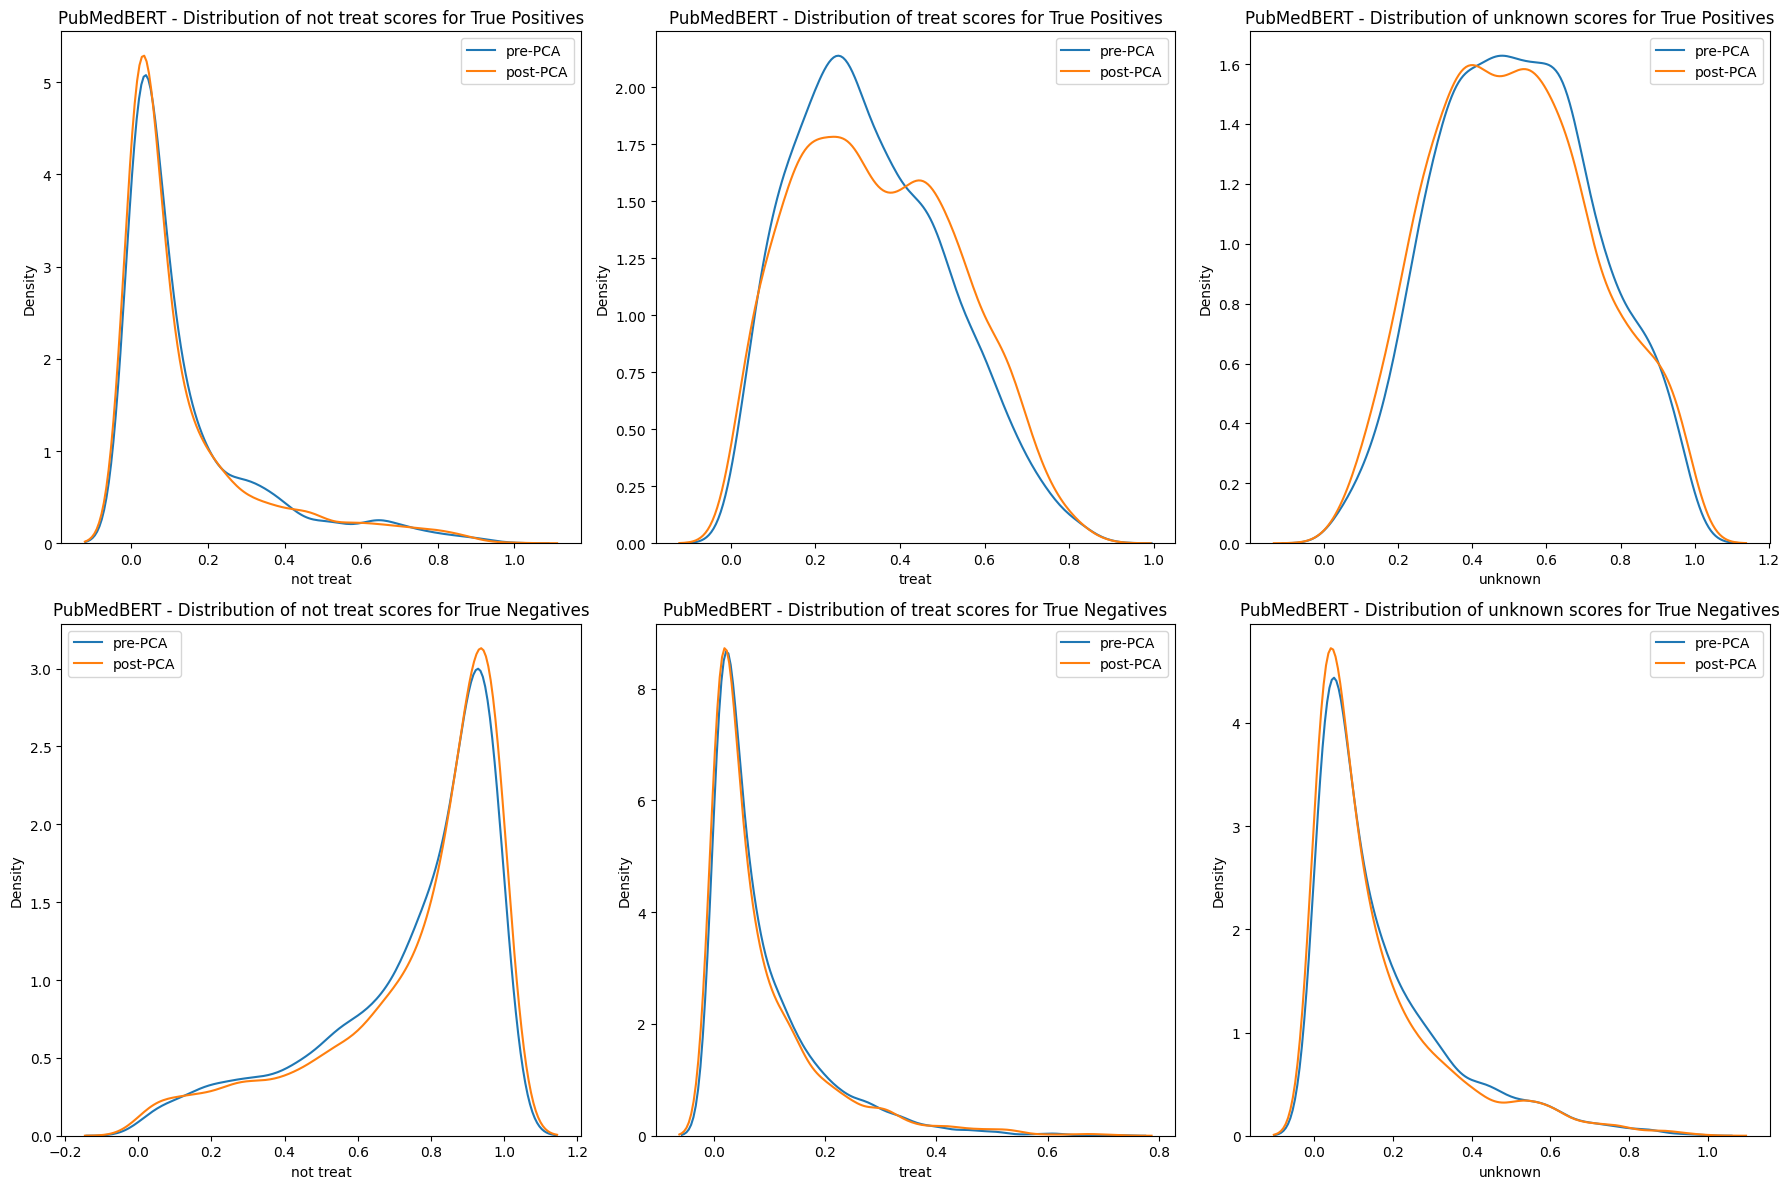

In [277]:
pubmed_df_full_2.columns=['not treat','treat', 'unknown']
pubmed_df_full_pca_2.columns=['not treat','treat', 'unknown']

pubmed_df_full_2['GT']=test.y
pubmed_df_full_pca_2['GT']=test.y

def plot_kde(ax, data, column, gt, title):
    sns.kdeplot(data=data.loc[data.GT==gt], x=column, ax=ax, label='pre-PCA')
    sns.kdeplot(data=pubmed_df_full_pca_2.loc[pubmed_df_full_pca_2.GT==gt], x=column, ax=ax, label='post-PCA')
    ax.set_title(title)
    ax.legend()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

plot_kde(axes[0, 0], pubmed_df_full_2, 'not treat', 1, 'PubMedBERT - Distribution of not treat scores for True Positives')
plot_kde(axes[0, 1], pubmed_df_full_2, 'treat', 1, 'PubMedBERT - Distribution of treat scores for True Positives')
plot_kde(axes[0, 2], pubmed_df_full_2, 'unknown', 1, 'PubMedBERT - Distribution of unknown scores for True Positives')

plot_kde(axes[1, 0], pubmed_df_full_2, 'not treat', 0, 'PubMedBERT - Distribution of not treat scores for True Negatives')
plot_kde(axes[1, 1], pubmed_df_full_2, 'treat', 0, 'PubMedBERT - Distribution of treat scores for True Negatives')
plot_kde(axes[1, 2], pubmed_df_full_2, 'unknown', 0, 'PubMedBERT - Distribution of unknown scores for True Negatives')

plt.tight_layout()
plt.show()

In [270]:
multi_index = pd.MultiIndex.from_arrays([['openai_full', 'openai_full', 'openai_full'],['not treat','treat','unknown']])
openai_df_full_2.columns = multi_index

multi_index = pd.MultiIndex.from_arrays([['openai_pca', 'openai_pca', 'openai_pca'],['not treat','treat','unknown']])
openai_df_full_pca_2.columns = multi_index

pd.concat([openai_df_full_2, openai_df_full_pca_2], axis=1)

openai_full                     openai_pca                    
       not treat     treat   unknown  not treat     treat   unknown
0       0.057758  0.142309  0.799934   0.082733  0.111946  0.805320
1       0.636241  0.254744  0.109015   0.632125  0.257831  0.110044
2       0.543972  0.344677  0.111352   0.504515  0.296480  0.199005
3       0.991648  0.001046  0.007306   0.989914  0.001109  0.008978
4       0.907403  0.060791  0.031806   0.936814  0.035416  0.027770
...          ...       ...       ...        ...       ...       ...
5458    0.132871  0.319596  0.547533   0.140729  0.227832  0.631439
5459    0.978795  0.006667  0.014538   0.978707  0.004400  0.016893
5460    0.027838  0.623570  0.348592   0.045911  0.429234  0.524856
5461    0.021895  0.507882  0.470224   0.052886  0.622116  0.324997
5462    0.716407  0.099528  0.184065   0.580643  0.132612  0.286745

[5463 rows x 6 columns]

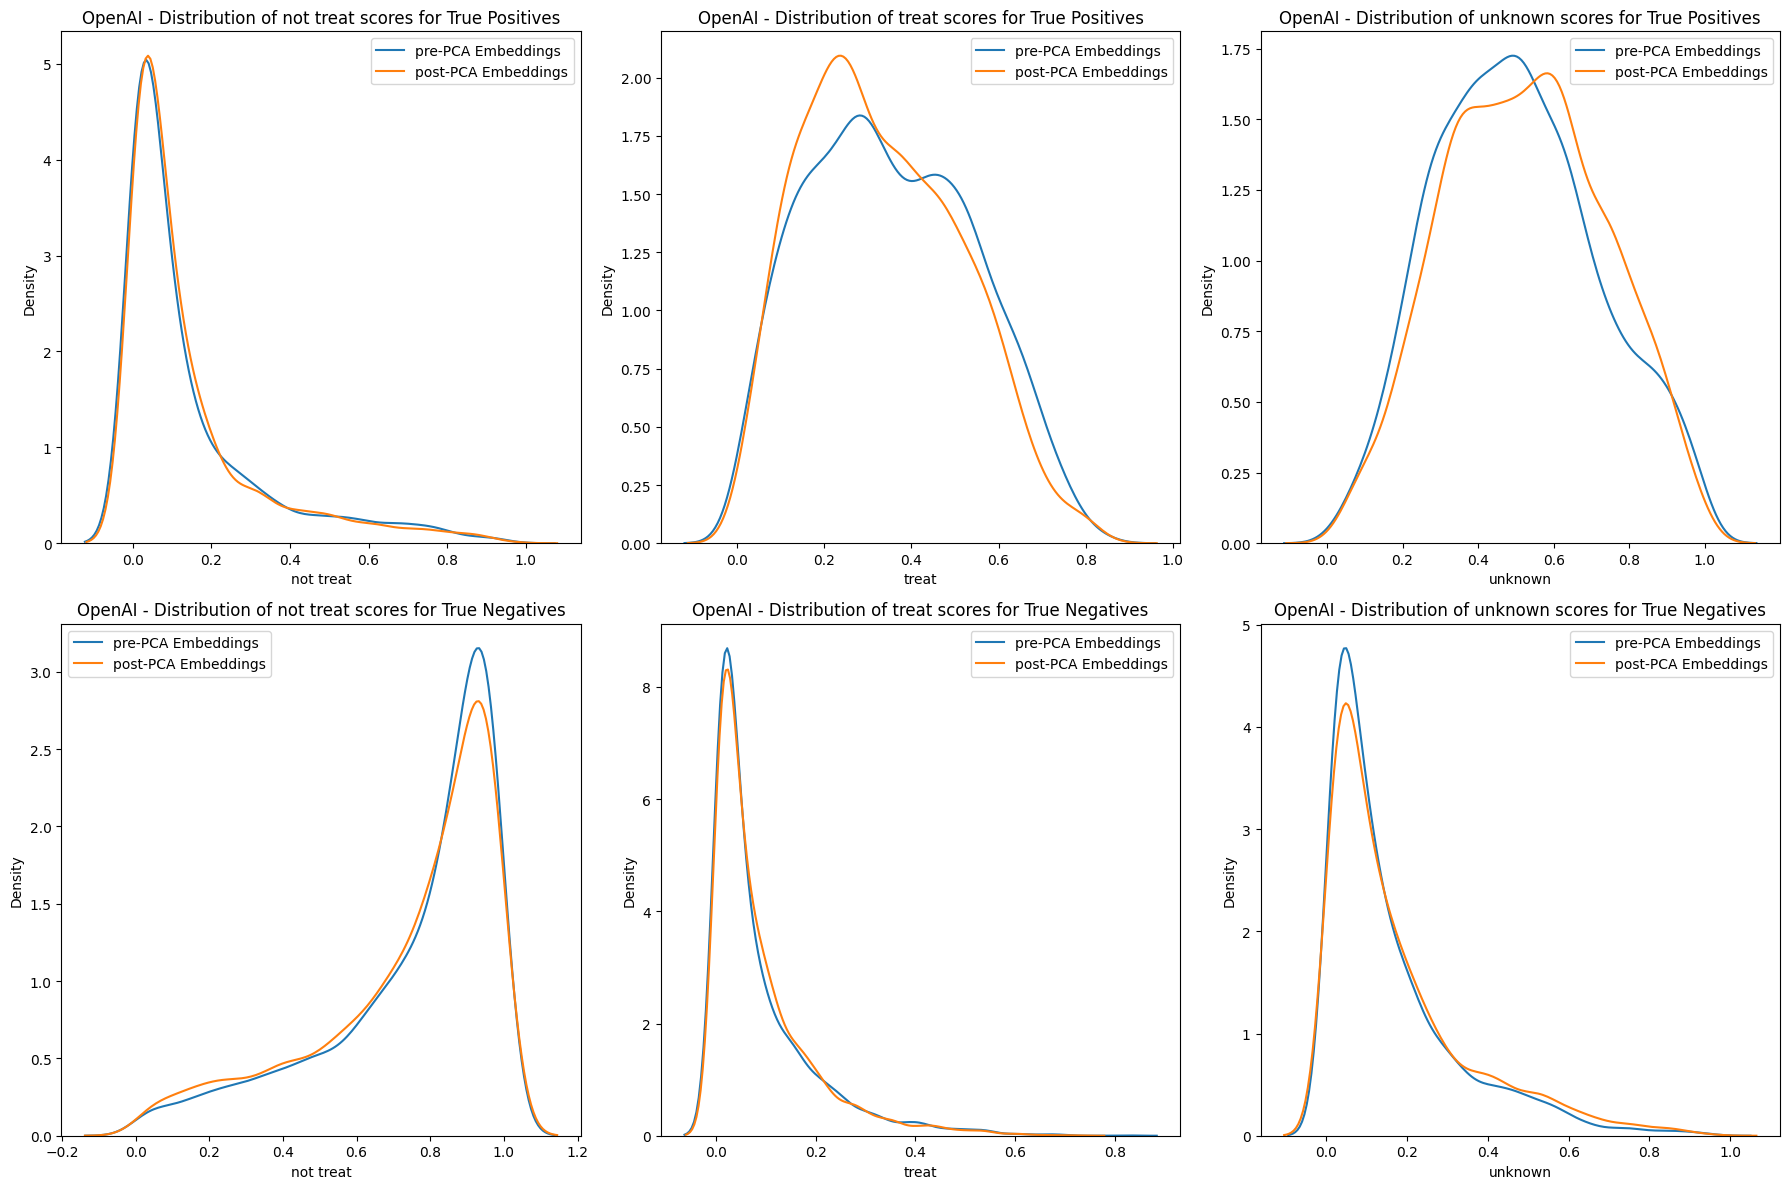

In [279]:
openai_df_full_2.columns=['not treat','treat', 'unknown']
openai_df_full_pca_2.columns=['not treat','treat', 'unknown']

openai_df_full_2['GT']=test.y
openai_df_full_pca_2['GT']=test.y

def plot_kde(ax, data, column, gt, title):
    sns.kdeplot(data=data.loc[data.GT==gt], x=column, ax=ax, label='pre-PCA Embeddings')
    sns.kdeplot(data=openai_df_full_pca_2.loc[openai_df_full_pca_2.GT==gt], x=column, ax=ax, label='post-PCA Embeddings')
    ax.set_title(title)
    ax.legend()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

plot_kde(axes[0, 0], openai_df_full_2, 'not treat', 1, 'OpenAI - Distribution of not treat scores for True Positives')
plot_kde(axes[0, 1], openai_df_full_2, 'treat', 1, 'OpenAI - Distribution of treat scores for True Positives')
plot_kde(axes[0, 2], openai_df_full_2, 'unknown', 1, 'OpenAI - Distribution of unknown scores for True Positives')

plot_kde(axes[1, 0], openai_df_full_2, 'not treat', 0, 'OpenAI - Distribution of not treat scores for True Negatives')
plot_kde(axes[1, 1], openai_df_full_2, 'treat', 0, 'OpenAI - Distribution of treat scores for True Negatives')
plot_kde(axes[1, 2], openai_df_full_2, 'unknown', 0, 'OpenAI - Distribution of unknown scores for True Negatives')

plt.tight_layout()
plt.show()

In [272]:
multi_index = pd.MultiIndex.from_arrays([['spacy_full', 'spacy_full', 'spacy_full'],['not treat','treat','unknown']])
spacy_df_full_2.columns = multi_index

multi_index = pd.MultiIndex.from_arrays([['spacy_pca', 'spacy_pca', 'spacy_pca'],['not treat','treat','unknown']])
spacy_df_full_pca_2.columns = multi_index

pd.concat([spacy_df_full_2, spacy_df_full_pca_2], axis=1)

spacy_full                     spacy_pca                    
      not treat     treat   unknown not treat     treat   unknown
0      0.182757  0.188780  0.628463  0.175772  0.191626  0.632602
1      0.246368  0.128133  0.625498  0.237872  0.123500  0.638628
2      0.562678  0.269908  0.167414  0.528088  0.298199  0.173713
3      0.733567  0.019269  0.247164  0.804142  0.011464  0.184394
4      0.235052  0.202074  0.562875  0.231813  0.193253  0.574934
...         ...       ...       ...       ...       ...       ...
5458   0.012921  0.172906  0.814173  0.010940  0.144690  0.844370
5459   0.217028  0.127906  0.655066  0.215520  0.125514  0.658966
5460   0.207279  0.128251  0.664470  0.205884  0.132547  0.661570
5461   0.030182  0.503747  0.466072  0.009028  0.689379  0.301593
5462   0.338041  0.243938  0.418021  0.312408  0.353092  0.334500

[5463 rows x 6 columns]

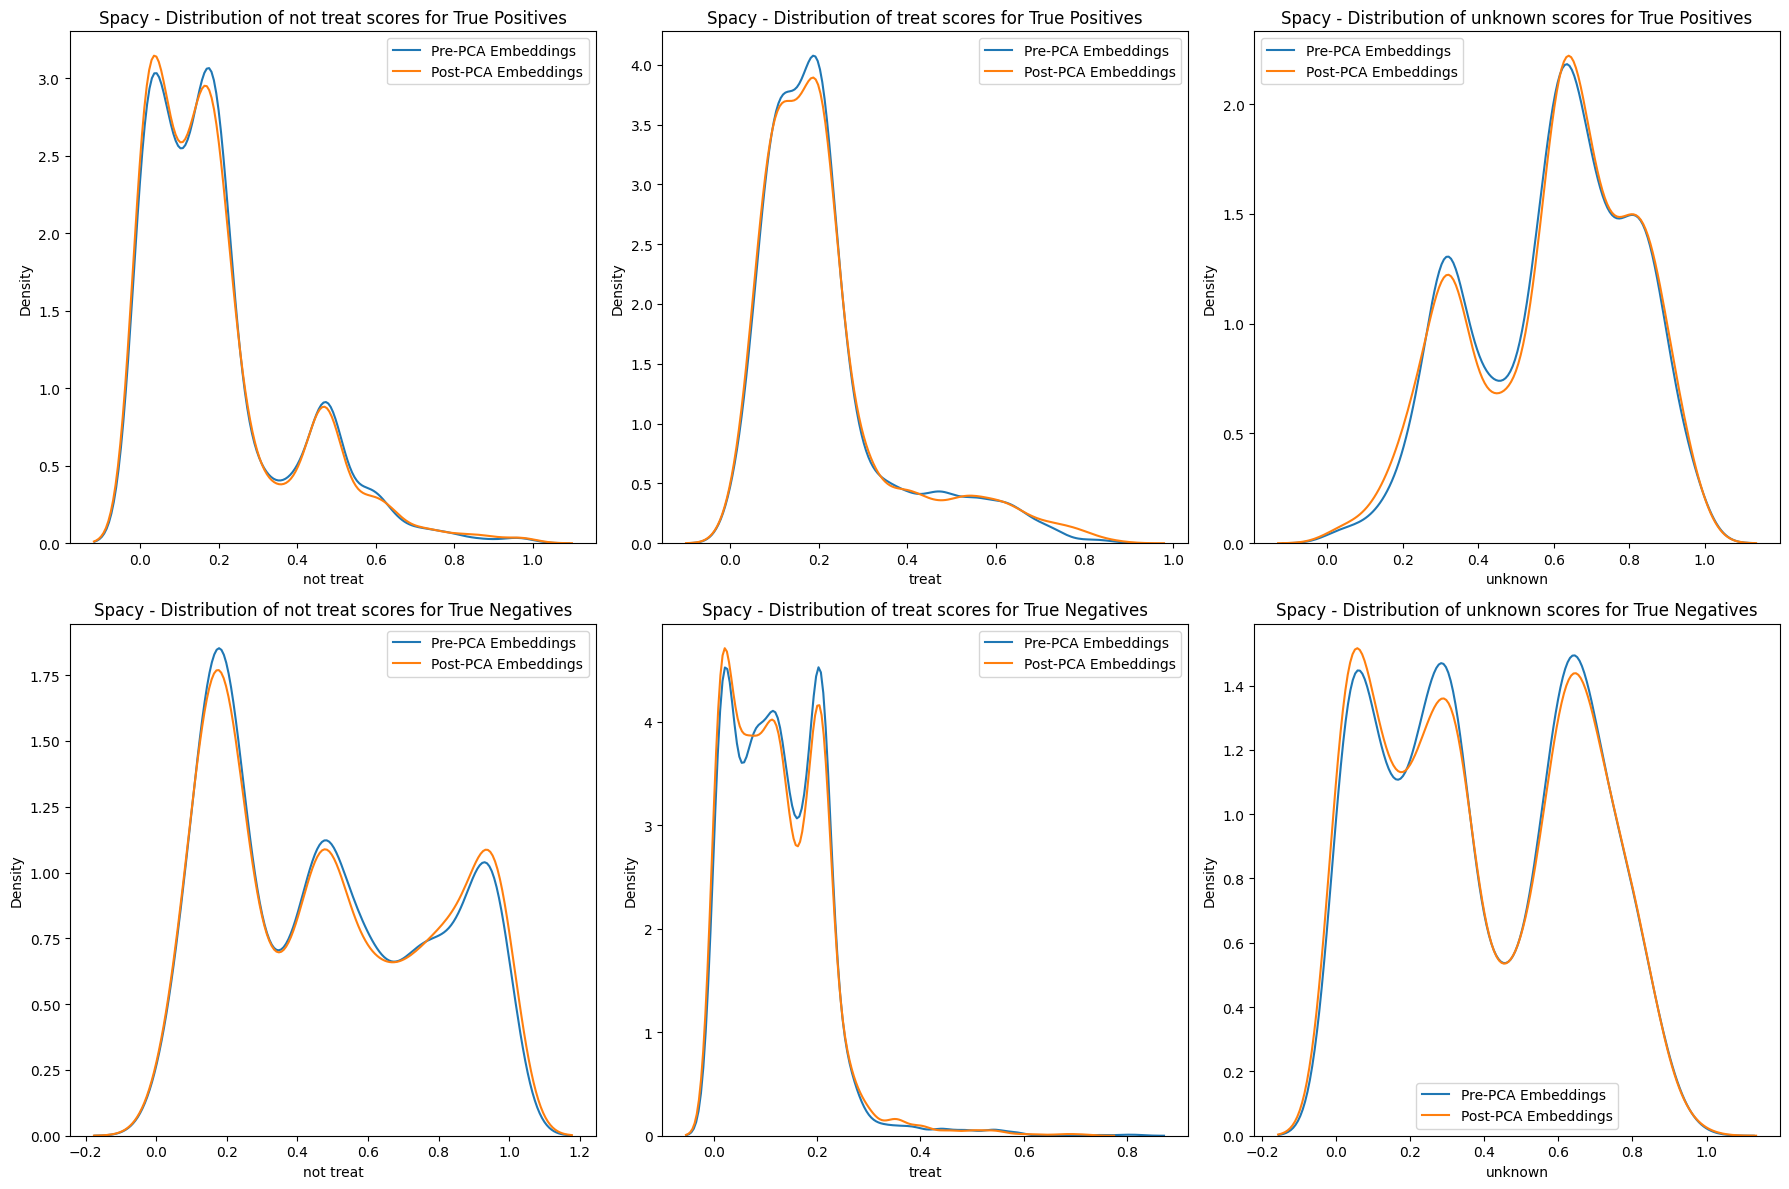

In [286]:
spacy_df_full_2.columns=['not treat','treat', 'unknown']
spacy_df_full_pca_2.columns=['not treat','treat', 'unknown']

spacy_df_full_2['GT']=test.y
spacy_df_full_pca_2['GT']=test.y

# Define a function to plot KDEs
def plot_kde(ax, data, column, gt, title):
    sns.kdeplot(data=data.loc[data.GT==gt], x=column, ax=ax, label='Pre-PCA Embeddings')
    sns.kdeplot(data=spacy_df_full_pca_2.loc[spacy_df_full_pca_2.GT==gt], x=column, ax=ax, label='Post-PCA Embeddings')
    ax.set_title(title)
    ax.legend()

# Create a 2x3 grid for subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot True Positives
plot_kde(axes[0, 0], spacy_df_full_2, 'not treat', 1, 'Spacy - Distribution of not treat scores for True Positives')
plot_kde(axes[0, 1], spacy_df_full_2, 'treat', 1, 'Spacy - Distribution of treat scores for True Positives')
plot_kde(axes[0, 2], spacy_df_full_2, 'unknown', 1, 'Spacy - Distribution of unknown scores for True Positives')

# Plot True Negatives
plot_kde(axes[1, 0], spacy_df_full_2, 'not treat', 0, 'Spacy - Distribution of not treat scores for True Negatives')
plot_kde(axes[1, 1], spacy_df_full_2, 'treat', 0, 'Spacy - Distribution of treat scores for True Negatives')
plot_kde(axes[1, 2], spacy_df_full_2, 'unknown', 0, 'Spacy - Distribution of unknown scores for True Negatives')

# Adjust layout
plt.tight_layout()
plt.show()

In [274]:
multi_index = pd.MultiIndex.from_arrays([['scispacy_full', 'scispacy_full', 'scispacy_full'],['not treat','treat','unknown']])
scispacy_df_full_2.columns = multi_index

multi_index = pd.MultiIndex.from_arrays([['scispacy_pca', 'scispacy_pca', 'scispacy_pca'],['not treat','treat','unknown']])
scispacy_df_full_pca_2.columns = multi_index

pd.concat([scispacy_df_full_2, scispacy_df_full_pca_2], axis=1)

scispacy_full                     scispacy_pca                    
         not treat     treat   unknown    not treat     treat   unknown
0         0.030091  0.007486  0.962423     0.006236  0.016466  0.977298
1         0.599685  0.075207  0.325108     0.008195  0.015039  0.976766
2         0.206731  0.045236  0.748033     0.008028  0.042162  0.949810
3         0.614293  0.046667  0.339040     0.014719  0.029688  0.955593
4         0.285454  0.166388  0.548158     0.018994  0.023673  0.957334
...            ...       ...       ...          ...       ...       ...
5458      0.063333  0.408500  0.528167     0.006418  0.033618  0.959964
5459      0.648043  0.066518  0.285439     0.009769  0.018891  0.971340
5460      0.086245  0.157364  0.756390     0.032851  0.030045  0.937104
5461      0.000000  0.792078  0.207922     0.015818  0.015641  0.968541
5462      0.077667  0.092333  0.830000     0.019749  0.044895  0.935356

[5463 rows x 6 columns]

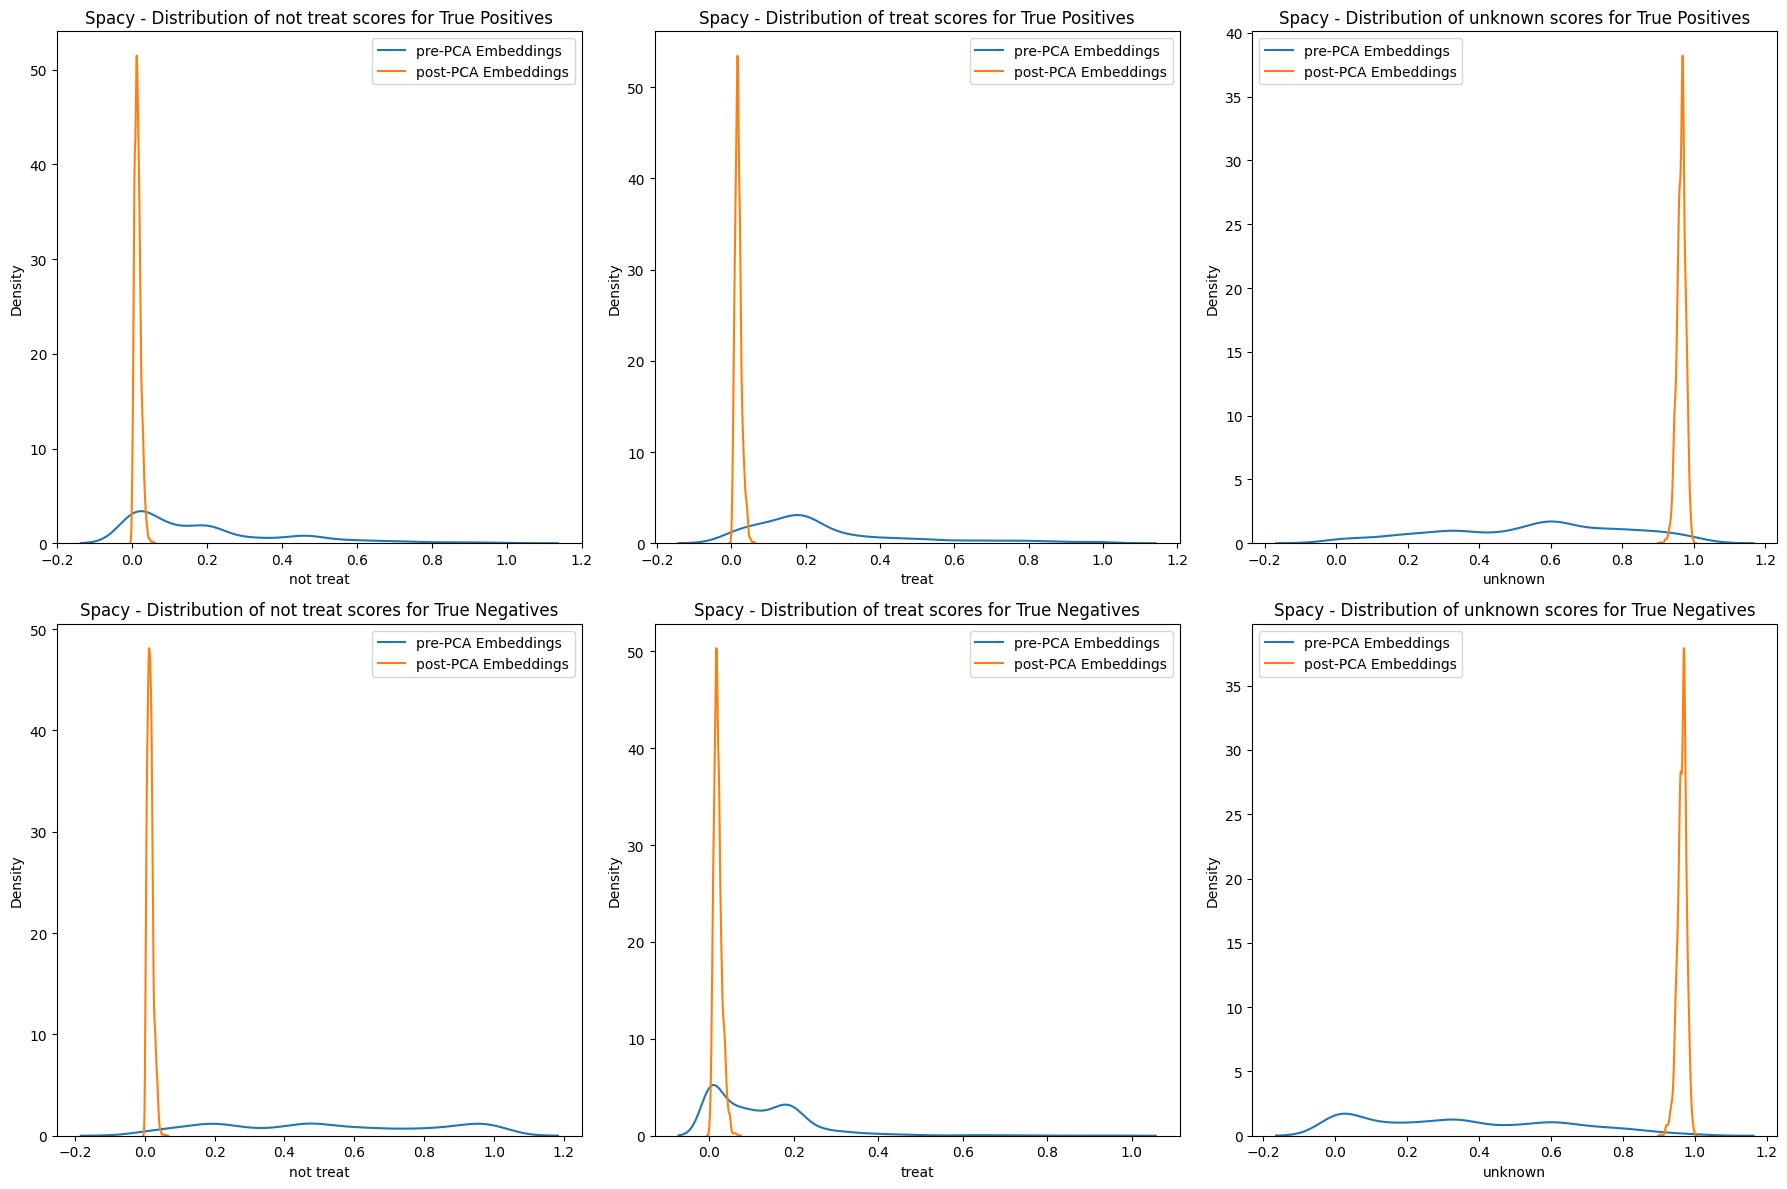

In [282]:
scispacy_df_full_2.columns=['not treat','treat', 'unknown']
scispacy_df_full_pca_2.columns=['not treat','treat', 'unknown']

scispacy_df_full_2['GT']=test.y
scispacy_df_full_pca_2['GT']=test.y

def plot_kde(ax, data, column, gt, title):
    sns.kdeplot(data=data.loc[data.GT==gt], x=column, ax=ax, label='pre-PCA Embeddings')
    sns.kdeplot(data=scispacy_df_full_pca_2.loc[scispacy_df_full_pca_2.GT==gt], x=column, ax=ax, label='post-PCA Embeddings')
    ax.set_title(title)
    ax.legend()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

plot_kde(axes[0, 0], scispacy_df_full_2, 'not treat', 1, 'Spacy - Distribution of not treat scores for True Positives')
plot_kde(axes[0, 1], scispacy_df_full_2, 'treat', 1, 'Spacy - Distribution of treat scores for True Positives')
plot_kde(axes[0, 2], scispacy_df_full_2, 'unknown', 1, 'Spacy - Distribution of unknown scores for True Positives')

plot_kde(axes[1, 0], scispacy_df_full_2, 'not treat', 0, 'Spacy - Distribution of not treat scores for True Negatives')
plot_kde(axes[1, 1], scispacy_df_full_2, 'treat', 0, 'Spacy - Distribution of treat scores for True Negatives')
plot_kde(axes[1, 2], scispacy_df_full_2, 'unknown', 0, 'Spacy - Distribution of unknown scores for True Negatives')

plt.tight_layout()
plt.show()

Again
* PubMedBERT and OpenAI distribution scores are quite similar
* PCA transformation doesn't impact the distirbution scores much
* Spacy distributions show moderately bad quality of embeddings
* Scispacy distributions show really bad quality of embeddings

# GraphSage Topological Embeddings
**Important note :** Note that I have not generated these graphsage topological embeddings. Here I am using topological PubMedBERT embeddings generated by Chunyu (which we used for training our classifiers) and compare them with PubMedBERT node embeddings I generated earlier on full data. While they are likely to differ slightly, I would expect almost identical behavior (note we dont have PubMedBERT node embeddings by Chunyu's so we cant do a proper comparison)

**Important note 2:** 15082024 Also note that here I am comparing OpenAI node embeddings I generated with OpenAI topological embeddings from the most recent pipeline run; again these should not differ much but I will need to rerun these classifiers with OpenAI node embeddings from the pipeline run to be 100% sure

### Load

In [10]:
#pubmedbert - load Chunyus embeddings
pubmed_graph = np.load('scratch/embeddings_original_graphsage_embeddings.npy')

In [ ]:
# note - here we are loading the OpenAI embeddings directly from BigQuery
# as it would take a while to query all 3 million nodes, I will only query nodes which are 
# needed (i.e. ones in train and test sets) and I will do it in batches (due to query character limit)

client = bigquery.Client()

drugs = list(set(train_df_1.source.values))
disease = list(set(train_df_1.target.values))
tdrugs = list(set(test.source.values))
tdisease = list(set(test.target.values))
drugs_diseases = drugs + disease + tdrugs + tdisease
node_ids = f"({str(drugs_diseases)[1:-1]})"

df_list=[]
for i in range(0, len(drugs_diseases), 1000):
    batch_ids = drugs_diseases[i:i + 1000]
    ids_str = '", "'.join(batch_ids)
    query = f'SELECT id, topological_embedding FROM `mtrx-hub-dev-3of.data_api.nodes_20240807` WHERE id IN ("{ids_str}")'
    query_job = client.query(query)
    results = query_job.to_arrow().to_pandas()
    df_list.append(results)
openai_graph = pd.concat(df_list, ignore_index=True)

np.save('scratch/openai_graphsage.npy', np.array(openai_graph))

## Test data no.1 (rasagoline -parkinsons)

In [68]:
#create sub-dfs
DRUG_TYPE = ['biolink:Drug', 'biolink:SmallMolecule']
DISEASE_TYPE = ['biolink:Disease', 'biolink:PhenotypicFeature', 'biolink:BehavioralFeature', 'biolink:DiseaseOrPhenotypicFeature']

#sample
sample_df_drugs = sample_df[sample_df['category'].isin(DRUG_TYPE)]
sample_df_disease = sample_df[sample_df['category'].isin(DISEASE_TYPE)]

#train test split 
train, test = train_test_split(gt, stratify=gt['y'], test_size=0.1, random_state=42)
train_tp_df = train[train['y']==1]
train_tp_df_drugs = train_tp_df['source'].reset_index(drop=True)
train_tp_df_diseases = train_tp_df['target'].reset_index(drop=True)
len_tp_tr = len(train_tp_df)
n_rep = 3

# create random drug-disease pairs
rand_drugs = sample_df_drugs['id'].sample(n_rep*len_tp_tr, replace=True, ignore_index = True, random_state = 2) # 42
rand_disease = sample_df_disease['id'].sample(n_rep*len_tp_tr, replace=True, ignore_index = True, random_state = 2) # 42
train_tp_diseases_copies = pd.concat([train_tp_df_diseases for _ in range(n_rep)], ignore_index = True)
train_tp_drugs_copies = pd.concat([train_tp_df_drugs for _ in range(n_rep)], ignore_index = True)
tmp_1 = pd.DataFrame({'source': rand_drugs, 'target': train_tp_diseases_copies, 'y': 2})
tmp_2 = pd.DataFrame({'source': train_tp_drugs_copies, 'target': rand_disease, 'y': 2})
un_data_1 =  pd.concat([tmp_1,tmp_2], ignore_index =True)
train_df_1 = pd.concat([train, un_data_1]).sample(frac=1).reset_index(drop=True)
test = test.reset_index(drop=True)

In [69]:
test

,source,target,y
0,CHEMBL.COMPOUND:CHEMBL1251,UMLS:C3544104,0
1,CHEMBL.COMPOUND:CHEMBL393336,MONDO:0007453,1
2,CHEMBL.COMPOUND:CHEMBL1356,MONDO:0005010,0
3,CHEMBL.COMPOUND:CHEMBL1201535,MONDO:0010743,0
4,CHEMBL.COMPOUND:CHEMBL538973,MONDO:0006731,1
...,...,...,...
5458,CHEMBL.COMPOUND:CHEMBL1723241,MONDO:0007019,1
5459,CHEMBL.COMPOUND:CHEMBL1200703,MONDO:0021011,0
5460,CHEMBL.COMPOUND:CHEMBL799,DOID:0060512,0
5461,CHEMBL.COMPOUND:CHEMBL1201535,MONDO:0010811,0


### Train Classifiers (topological embeddings)

In [ ]:
feature_length = 1024

# Precompute lookup dictionaries
drug_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}
disease_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}

X_pubmed = np.empty((len(train_df_1), feature_length), dtype='float32')
drug_indices = train_df_1['source'].map(drug_id_dict)
disease_indices = train_df_1['target'].map(disease_id_dict)

for index in tqdm(range(len(train_df_1))):
    drug_vector = pubmed_graph[drug_indices.iloc[index]]
    disease_vector = pubmed_graph[disease_indices.iloc[index]]
    X_pubmed[index] = np.concatenate([drug_vector, disease_vector])

y_pubmed = train_df_1.y.to_numpy()

# For the test dataset
test = test.reset_index(drop=True)
X_pubmed_test = np.empty((len(test), feature_length), dtype='float32')

test_drug_indices = test['source'].map(drug_id_dict)
test_disease_indices = test['target'].map(disease_id_dict)

for index in tqdm(range(len(test))):
    drug_vector = pubmed_graph[test_drug_indices.iloc[index]]
    disease_vector = pubmed_graph[test_disease_indices.iloc[index]]
    X_pubmed_test[index] = np.concatenate([drug_vector, disease_vector])

y_pubmed_test = test.y.to_numpy()

In [ ]:
# xgboost
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_pubmed, y_pubmed)

y_pubmed_pred = xgb.predict_proba(X_pubmed_test)
y_pubmed_proba = xgb.predict_proba(X_pubmed_test)

print('xgboost scores (not treat; treat; unknown)')
print(y_pubmed_proba)

pubmed_df_full_graph_1 = pd.DataFrame(y_pubmed_proba)
pubmed_df_full_graph_1.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
pubmed_df_full_graph_1.to_csv('scratch/pubmed_df_graphsage_xgb_1.csv')

# random forest
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_pubmed, y_pubmed)

y_pubmed_pred = rf_clf.predict_proba(X_pubmed_test)
y_pubmed_proba = rf_clf.predict_proba(X_pubmed_test)

print('random forest scores (not treat; treat; unknown)')
print(y_pubmed_proba)

pubmed_df_full_graph_rf_1 = pd.DataFrame(y_pubmed_proba)
pubmed_df_full_graph_rf_1.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
pubmed_df_full_graph_rf_1.to_csv('scratch/pubmed_df_graphsage_rf_1.csv')


In [150]:

# Create a dictionary for fast lookup
embedding_dict = openai_graph.set_index('id')['topological_embedding'].to_dict()

# Initialize feature matrices
feature_length = 1024
X_openai = np.empty((len(train_df_1), feature_length), dtype='float32')
X_openai_test = np.empty((len(test), feature_length), dtype='float32')

# Function to get concatenated vectors
def get_concatenated_vector(row):
    drug_vector = embedding_dict[row['source']]
    disease_vector = embedding_dict[row['target']]
    return np.concatenate([drug_vector, disease_vector])

# Apply the function to each row of train_df_1
X_openai = np.vstack(train_df_1.apply(get_concatenated_vector, axis=1))

# Convert target variable to numpy array
y_openai = train_df_1['y'].to_numpy()

# Reset index for test DataFrame
test = test.reset_index(drop=True)

X_openai_test = np.vstack(test.apply(get_concatenated_vector, axis=1))

y_openai_test = test['y'].to_numpy()

In [ ]:
# xgboost
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_openai, y_openai)

y_openai_pred = xgb.predict_proba(X_openai_test)
y_openai_proba = xgb.predict_proba(X_openai_test)

print('xgboost scores (not treat; treat; unknown)')
print(y_openai_proba)

openai_df_full_graph_1 = pd.DataFrame(y_openai_proba)
openai_df_full_graph_1.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
openai_df_full_graph_xgb_1.to_csv('scratch/openai_df_graphsage_xgb_1.csv')

# random forest
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_openai, y_openai)

y_openai_pred = rf_clf.predict_proba(X_openai_test)
y_openai_proba = rf_clf.predict_proba(X_openai_test)

print('random forest scores (not treat; treat; unknown)')
print(y_openai_proba)

openai_df_full_graph_rf_1 = pd.DataFrame(y_openai_proba)
openai_df_full_graph_rf_1.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
openai_df_full_graph_rf_1.to_csv('scratch/openai_df_graphsage_rf_1.csv')

### Summary

In [174]:
pubmed_df_full_1 = pd.read_csv('scratch/pubmed_df_full_xgb_1.csv', index_col=0)

pubmed_df_full_pca_1 = pd.read_csv('scratch/pubmed_df_pca_xgb_1.csv', index_col=0)

pubmed_df_full_graph_1 = pd.read_csv('scratch/pubmed_df_graphsage_xgb_1.csv', index_col=0)

In [175]:
multi_index = pd.MultiIndex.from_arrays([['pubmed_full_attribute', 'pubmed_full_attribute', 'pubmed_full_attribute'],['not treat','treat','unknown']])
pubmed_df_full_1.columns = multi_index

multi_index = pd.MultiIndex.from_arrays([['pubmed_pca_attribute', 'pubmed_pca_attribute', 'pubmed_pca_attribute'],['not treat','treat','unknown']])
pubmed_df_full_pca_1.columns = multi_index

multi_index = pd.MultiIndex.from_arrays([['pubmed_full_topological', 'pubmed_full_topological', 'pubmed_full_topological'],['not treat','treat','unknown']])
pubmed_df_full_graph_1.columns = multi_index

pd.concat([pubmed_df_full_1, pubmed_df_full_pca_1, pubmed_df_full_graph_1], axis=1)

pubmed_full_attribute                     pubmed_pca_attribute            \
                 not treat     treat   unknown            not treat     treat   
0                  0.37000  0.171111  0.458889             0.974509  0.003670   
1                  0.11000  0.420000  0.470000             0.241604  0.377149   
2                  0.68000  0.140000  0.180000             0.831076  0.024478   
3                  1.00000  0.000000  0.000000             0.989245  0.003101   
4                  0.18125  0.333750  0.485000             0.548862  0.098745   
...                    ...       ...       ...                  ...       ...   
5458               0.05000  0.470000  0.480000             0.052133  0.505461   
5459               0.86000  0.100000  0.040000             0.889710  0.018209   
5460               1.00000  0.000000  0.000000             0.924684  0.021874   
5461               0.93000  0.020000  0.050000             0.930755  0.029351   
5462               0.07000  0.440000  0.490000             0.068733  0.460935   

               pubmed_full_topological                      
       unknown               not treat     treat   unknown  
0     0.021821                0.805292  0.018282  0.176426  
1     0.381247                0.152287  0.485655  0.362058  
2     0.144445                0.849664  0.101137  0.049198  
3     0.007654                0.987451  0.003194  0.009355  
4     0.352393                0.360367  0.373801  0.265832  
...        ...                     ...       ...       ...  
5458  0.442406                0.334177  0.162478  0.503345  
5459  0.092081                0.720327  0.090946  0.188727  
5460  0.053442                0.911873  0.031981  0.056146  
5461  0.039894                0.932091  0.047357  0.020552  
5462  0.470332                0.063025  0.301237  0.635738  

[5463 rows x 9 columns]

In [176]:
openai_df_full_1 = pd.read_csv('scratch/openai_df_full_xgb_1.csv', index_col=0)

openai_df_full_pca_1 = pd.read_csv('scratch/openai_df_pca_xgb_1.csv', index_col=0)

#openai_df_full_graph_2 = pd.read_csv('scratch/openai_df_graphsage_xgb_2.csv', index_col=0)

In [177]:
multi_index = pd.MultiIndex.from_arrays([['openai_full_attribute', 'openai_full_attribute', 'openai_full_attribute'],['not treat','treat','unknown']])
openai_df_full_1.columns = multi_index

multi_index = pd.MultiIndex.from_arrays([['openai_pca_attribute', 'openai_pca_attribute', 'openai_pca_attribute'],['not treat','treat','unknown']])
openai_df_full_pca_1.columns = multi_index

multi_index = pd.MultiIndex.from_arrays([['openai_full_topological', 'openai_full_topological', 'openai_full_topological'],['not treat','treat','unknown']])
openai_df_full_graph_1.columns = multi_index

pd.concat([openai_df_full_1, openai_df_full_pca_1, openai_df_full_graph_1], axis=1)

openai_full_attribute                     openai_pca_attribute            \
                 not treat     treat   unknown            not treat     treat   
0                 0.838094  0.012893  0.149013             0.968259  0.004215   
1                 0.132875  0.475239  0.391887             0.196416  0.407204   
2                 0.785355  0.029391  0.185254             0.944848  0.005484   
3                 0.984881  0.004791  0.010328             0.990759  0.001061   
4                 0.444666  0.194694  0.360639             0.582352  0.144675   
...                    ...       ...       ...                  ...       ...   
5458              0.195879  0.276766  0.527355             0.131768  0.438028   
5459              0.816770  0.053965  0.129266             0.815622  0.020668   
5460              0.954698  0.023397  0.021905             0.963987  0.009705   
5461              0.949466  0.028325  0.022209             0.944134  0.030150   
5462              0.167932  0.503467  0.328601             0.102555  0.555085   

               openai_full_topological                      
       unknown               not treat     treat   unknown  
0     0.027526                0.800822  0.005686  0.193492  
1     0.396380                0.046878  0.731888  0.221235  
2     0.049669                0.699168  0.112019  0.188813  
3     0.008180                0.848106  0.044875  0.107018  
4     0.272973                0.021522  0.097908  0.880570  
...        ...                     ...       ...       ...  
5458  0.430204                0.196660  0.576064  0.227276  
5459  0.163710                0.606453  0.058379  0.335167  
5460  0.026308                0.855290  0.071856  0.072854  
5461  0.025716                0.779798  0.100113  0.120089  
5462  0.342359                0.043154  0.463743  0.493103  

[5463 rows x 9 columns]

In [215]:
pubmed_df_full_1.columns=['not treat','treat', 'unknown']
pubmed_df_full_graph_1.columns=['not treat','treat', 'unknown']

openai_df_full_1.columns=['not treat','treat', 'unknown']
openai_df_full_graph_1.columns=['not treat','treat', 'unknown']

pubmed_df_full_1['GT']=test.y
pubmed_df_full_graph_1['GT']=test.y
openai_df_full_1['GT']=test.y
openai_df_full_graph_1['GT']=test.y

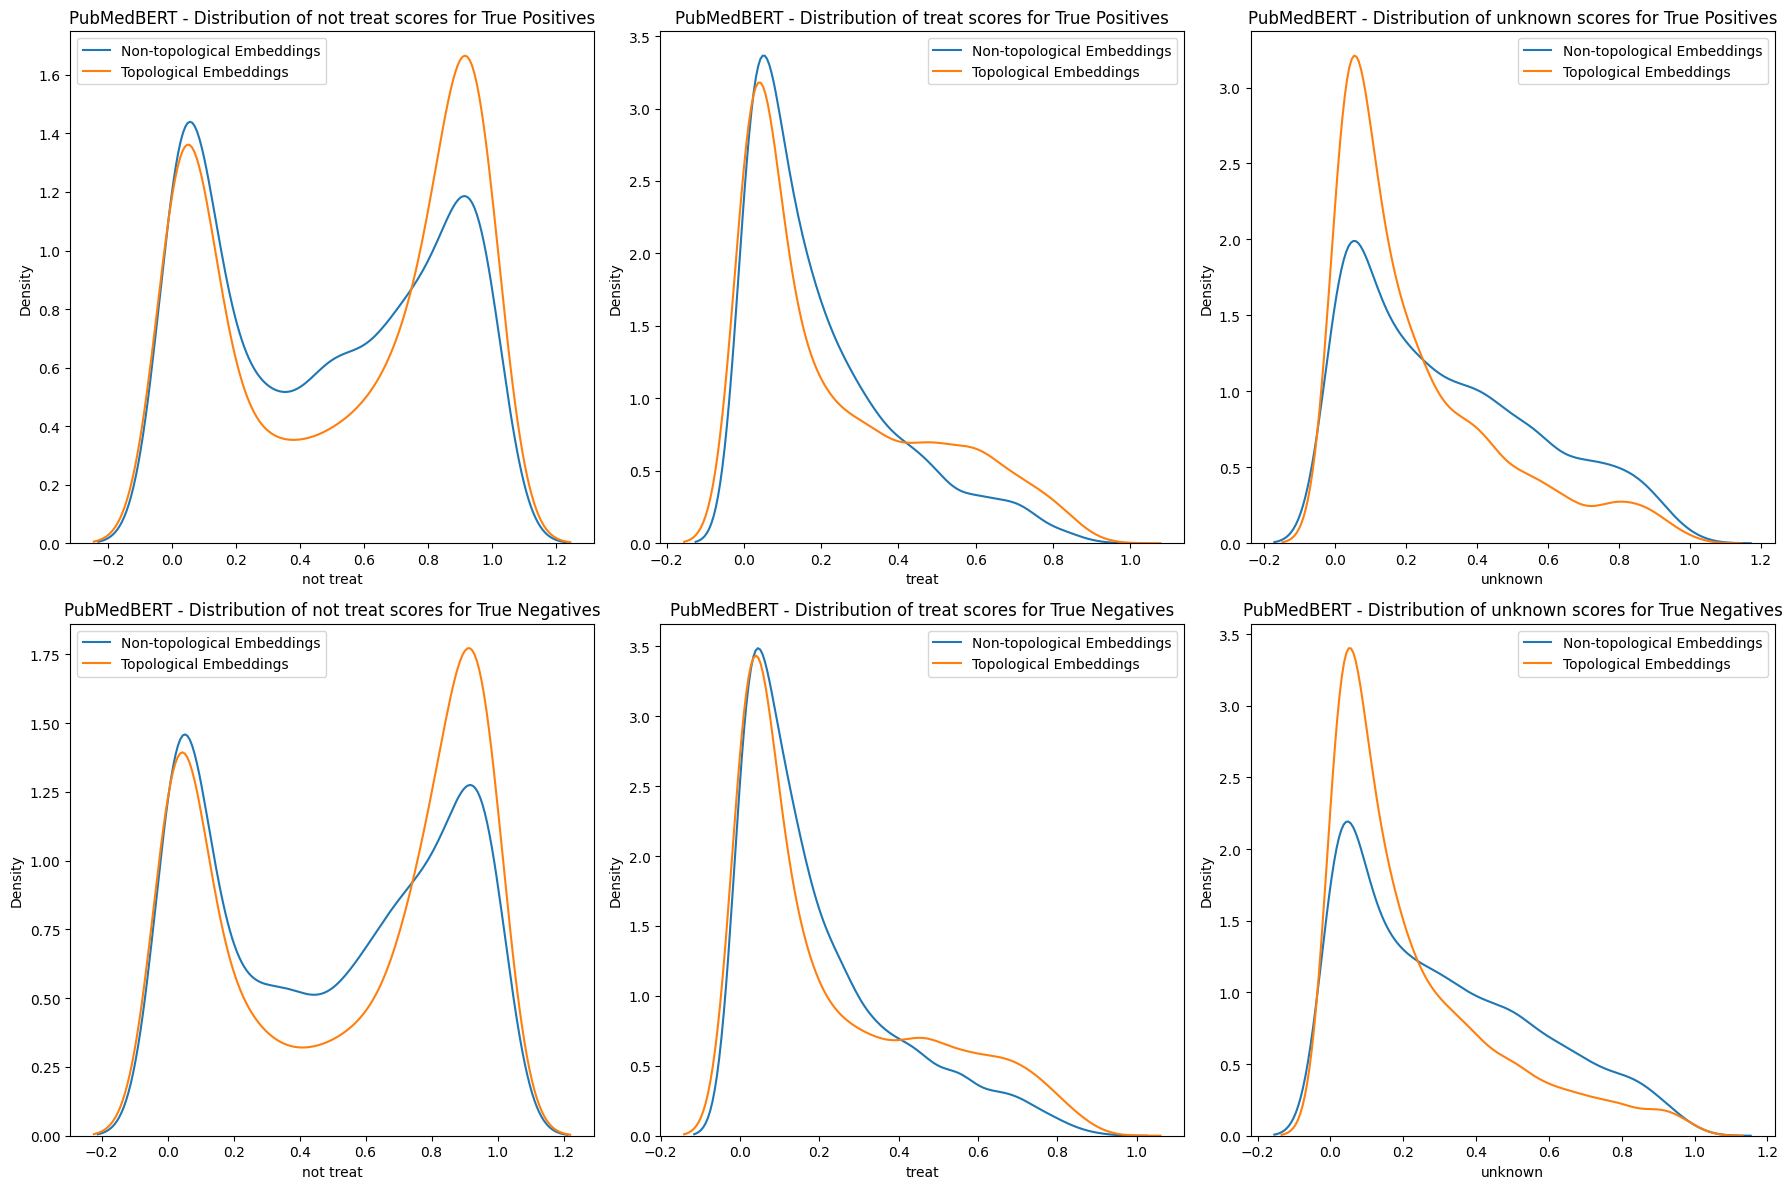

In [216]:
# Define a function to plot KDEs
def plot_kde(ax, data, column, gt, title):
    sns.kdeplot(data=data.loc[data.GT==gt], x=column, ax=ax, label='Non-topological Embeddings')
    sns.kdeplot(data=pubmed_df_full_graph_1.loc[pubmed_df_full_graph_1.GT==gt], x=column, ax=ax, label='Topological Embeddings')
    ax.set_title(title)
    ax.legend()

# Create a 2x3 grid for subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot True Positives
plot_kde(axes[0, 0], pubmed_df_full_1, 'not treat', 1, 'PubMedBERT - Distribution of not treat scores for True Positives')
plot_kde(axes[0, 1], pubmed_df_full_1, 'treat', 1, 'PubMedBERT - Distribution of treat scores for True Positives')
plot_kde(axes[0, 2], pubmed_df_full_1, 'unknown', 1, 'PubMedBERT - Distribution of unknown scores for True Positives')

# Plot True Negatives
plot_kde(axes[1, 0], pubmed_df_full_1, 'not treat', 0, 'PubMedBERT - Distribution of not treat scores for True Negatives')
plot_kde(axes[1, 1], pubmed_df_full_1, 'treat', 0, 'PubMedBERT - Distribution of treat scores for True Negatives')
plot_kde(axes[1, 2], pubmed_df_full_1, 'unknown', 0, 'PubMedBERT - Distribution of unknown scores for True Negatives')

# Adjust layout
plt.tight_layout()
plt.show()

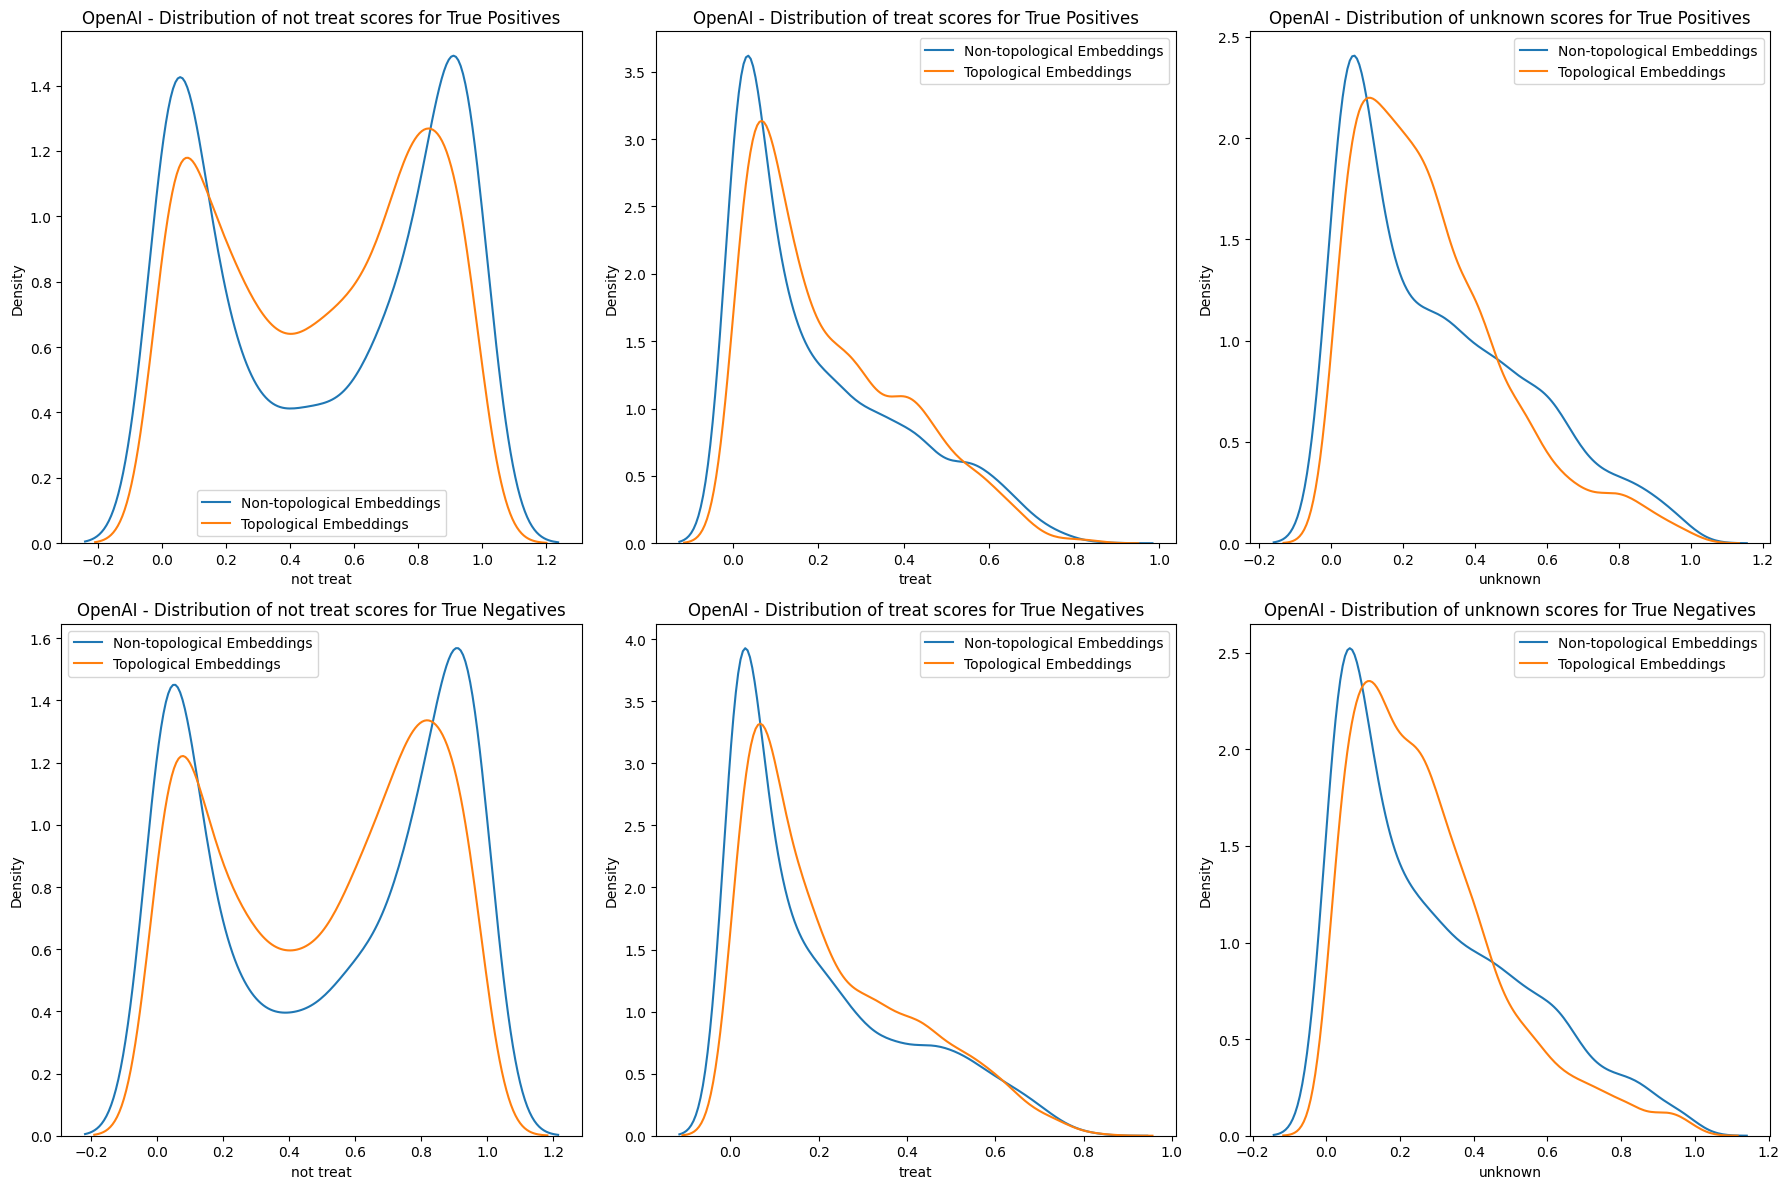

In [218]:

# Define a function to plot KDEs
def plot_kde(ax, data, column, gt, title):
    sns.kdeplot(data=data.loc[data.GT==gt], x=column, ax=ax, label='Non-topological Embeddings')
    sns.kdeplot(data=openai_df_full_graph_1.loc[openai_df_full_graph_1.GT==gt], x=column, ax=ax, label='Topological Embeddings')
    ax.set_title(title)
    ax.legend()

# Create a 2x3 grid for subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot True Positives
plot_kde(axes[0, 0], openai_df_full_1, 'not treat', 1, 'OpenAI - Distribution of not treat scores for True Positives')
plot_kde(axes[0, 1], openai_df_full_1, 'treat', 1, 'OpenAI - Distribution of treat scores for True Positives')
plot_kde(axes[0, 2], openai_df_full_1, 'unknown', 1, 'OpenAI - Distribution of unknown scores for True Positives')

# Plot True Negatives
plot_kde(axes[1, 0], openai_df_full_1, 'not treat', 0, 'OpenAI - Distribution of not treat scores for True Negatives')
plot_kde(axes[1, 1], openai_df_full_1, 'treat', 0, 'OpenAI - Distribution of treat scores for True Negatives')
plot_kde(axes[1, 2], openai_df_full_1, 'unknown', 0, 'OpenAI - Distribution of unknown scores for True Negatives')

# Adjust layout
plt.tight_layout()
plt.show()

## Test no.2 (cloxotestosterone - prostate carcinoma)

In [160]:
from sklearn.model_selection import train_test_split
#create sub-dfs
DRUG_TYPE = ['biolink:Drug', 'biolink:SmallMolecule']
DISEASE_TYPE = ['biolink:Disease', 'biolink:PhenotypicFeature', 'biolink:BehavioralFeature', 'biolink:DiseaseOrPhenotypicFeature']

#sample
sample_df_drugs = sample_df[sample_df['category'].isin(DRUG_TYPE)]
sample_df_disease = sample_df[sample_df['category'].isin(DISEASE_TYPE)]

#train test split 
train, test = train_test_split(gt, stratify=gt['y'], test_size=0.1, random_state=2)
train_tp_df = train[train['y']==1]
train_tp_df_drugs = train_tp_df['source'].reset_index(drop=True)
train_tp_df_diseases = train_tp_df['target'].reset_index(drop=True)
len_tp_tr = len(train_tp_df)
n_rep = 3

# create random drug-disease pairs
rand_drugs = sample_df_drugs['id'].sample(n_rep*len_tp_tr, replace=True, ignore_index = True, random_state = 42) # 42
rand_disease = sample_df_disease['id'].sample(n_rep*len_tp_tr, replace=True, ignore_index = True, random_state = 42) # 42
train_tp_diseases_copies = pd.concat([train_tp_df_diseases for _ in range(n_rep)], ignore_index = True)
train_tp_drugs_copies = pd.concat([train_tp_df_drugs for _ in range(n_rep)], ignore_index = True)
tmp_1 = pd.DataFrame({'source': rand_drugs, 'target': train_tp_diseases_copies, 'y': 2})
tmp_2 = pd.DataFrame({'source': train_tp_drugs_copies, 'target': rand_disease, 'y': 2})
un_data_1 =  pd.concat([tmp_1,tmp_2], ignore_index =True)
train_df_1 = pd.concat([train, un_data_1]).sample(frac=1).reset_index(drop=True)
test = test.reset_index(drop=True)

### Train Classifiers (topological embeddings)

In [ ]:
feature_length = 1024

drug_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}
disease_id_dict = {id_: idx for idx, id_ in enumerate(sample_df.id)}

X_pubmed = np.empty((len(train_df_1), feature_length), dtype='float32')
drug_indices = train_df_1['source'].map(drug_id_dict)
disease_indices = train_df_1['target'].map(disease_id_dict)

for index in tqdm(range(len(train_df_1))):
    drug_vector = pubmed_graph[drug_indices.iloc[index]]
    disease_vector = pubmed_graph[disease_indices.iloc[index]]
    X_pubmed[index] = np.concatenate([drug_vector, disease_vector])

y_pubmed = train_df_1.y.to_numpy()

test = test.reset_index(drop=True)
X_pubmed_test = np.empty((len(test), feature_length), dtype='float32')

test_drug_indices = test['source'].map(drug_id_dict)
test_disease_indices = test['target'].map(disease_id_dict)

for index in tqdm(range(len(test))):
    drug_vector = pubmed_graph[test_drug_indices.iloc[index]]
    disease_vector = pubmed_graph[test_disease_indices.iloc[index]]
    X_pubmed_test[index] = np.concatenate([drug_vector, disease_vector])

y_pubmed_test = test.y.to_numpy()

In [ ]:
# xgboost
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_pubmed, y_pubmed)

y_pubmed_pred = xgb.predict_proba(X_pubmed_test)
y_pubmed_proba = xgb.predict_proba(X_pubmed_test)

print('xgboost scores (not treat; treat; unknown)')
print(y_pubmed_proba)

pubmed_df_full_graph_2 = pd.DataFrame(y_pubmed_proba)
pubmed_df_full_graph_2.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
pubmed_df_full_graph_2.to_csv('scratch/pubmed_df_graphsage_xgb_2.csv')

# random forest
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_pubmed, y_pubmed)

y_pubmed_pred = rf_clf.predict_proba(X_pubmed_test)
y_pubmed_proba = rf_clf.predict_proba(X_pubmed_test)

print('random forest scores (not treat; treat; unknown)')
print(y_pubmed_proba)

pubmed_df_full_graph_rf_2 = pd.DataFrame(y_pubmed_proba)
pubmed_df_full_graph_rf_2.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
pubmed_df_full_graph_rf_2.to_csv('scratch/pubmed_df_graphsage_rf_2.csv')


In [161]:

embedding_dict = openai_graph.set_index('id')['topological_embedding'].to_dict()

feature_length = 1024
X_openai = np.empty((len(train_df_1), feature_length), dtype='float32')
X_openai_test = np.empty((len(test), feature_length), dtype='float32')

def get_concatenated_vector(row):
    drug_vector = embedding_dict[row['source']]
    disease_vector = embedding_dict[row['target']]
    return np.concatenate([drug_vector, disease_vector])

X_openai = np.vstack(train_df_1.apply(get_concatenated_vector, axis=1))

y_openai = train_df_1['y'].to_numpy()
test = test.reset_index(drop=True)

X_openai_test = np.vstack(test.apply(get_concatenated_vector, axis=1))
y_openai_test = test['y'].to_numpy()

In [ ]:
# xgboost
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_openai, y_openai)

y_openai_pred = xgb.predict_proba(X_openai_test)
y_openai_proba = xgb.predict_proba(X_openai_test)

print('xgboost scores (not treat; treat; unknown)')
print(y_openai_proba)

openai_df_full_graph_2 = pd.DataFrame(y_openai_proba)
openai_df_full_graph_2.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
openai_df_full_graph_2.to_csv('scratch/openai_df_graphsage_xgb_2.csv')

# random forest
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_openai, y_openai)

y_openai_pred = rf_clf.predict_proba(X_openai_test)
y_openai_proba = rf_clf.predict_proba(X_openai_test)

print('random forest scores (not treat; treat; unknown)')
print(y_openai_proba)

openai_df_full_graph_rf_2 = pd.DataFrame(y_openai_proba)
openai_df_full_graph_rf_2.columns = ['not-treat-score', 'treat-score', 'unknown-treat-score']
openai_df_full_graph_rf_2.to_csv('scratch/openai_df_graphsage_rf_2.csv')

### Summary

In [169]:
multi_index = pd.MultiIndex.from_arrays([['pubmed_full_attribute', 'pubmed_full_attribute', 'pubmed_full_attribute'],['not treat','treat','unknown']])
pubmed_df_full_2.columns = multi_index

multi_index = pd.MultiIndex.from_arrays([['pubmed_pca_attribute', 'pubmed_pca_attribute', 'pubmed_pca_attribute'],['not treat','treat','unknown']])
pubmed_df_full_pca_2.columns = multi_index

multi_index = pd.MultiIndex.from_arrays([['pubmed_full_topological', 'pubmed_full_topological', 'pubmed_full_topological'],['not treat','treat','unknown']])
pubmed_df_full_graph_2.columns = multi_index

pd.concat([pubmed_df_full_2, pubmed_df_full_pca_2, pubmed_df_full_graph_2], axis=1)

pubmed_full_attribute                     pubmed_pca_attribute            \
                 not treat     treat   unknown            not treat     treat   
0                 0.117798  0.118287  0.763915             0.072641  0.187802   
1                 0.589176  0.265240  0.145585             0.556022  0.296397   
2                 0.446263  0.398724  0.155013             0.525127  0.363614   
3                 0.990449  0.002232  0.007318             0.980491  0.000881   
4                 0.928869  0.037750  0.033381             0.909297  0.059093   
...                    ...       ...       ...                  ...       ...   
5458              0.319558  0.178982  0.501460             0.118548  0.318278   
5459              0.947869  0.013817  0.038314             0.937161  0.014934   
5460              0.043970  0.351083  0.604947             0.041160  0.470196   
5461              0.043225  0.670625  0.286150             0.051744  0.479666   
5462              0.823113  0.062718  0.114169             0.573162  0.223280   

               pubmed_full_topological                      
       unknown               not treat     treat   unknown  
0     0.739556                0.137959  0.383204  0.478836  
1     0.147581                0.664248  0.290710  0.045042  
2     0.111259                0.685186  0.209262  0.105552  
3     0.018628                0.991186  0.002083  0.006730  
4     0.031610                0.930941  0.045049  0.024010  
...        ...                     ...       ...       ...  
5458  0.563174                0.203076  0.332653  0.464272  
5459  0.047906                0.969938  0.015768  0.014294  
5460  0.488644                0.004905  0.879606  0.115490  
5461  0.468591                0.036345  0.639021  0.324635  
5462  0.203558                0.599902  0.206626  0.193472  

[5463 rows x 9 columns]

In [171]:
multi_index = pd.MultiIndex.from_arrays([['openai_full_attribute', 'openai_full_attribute', 'openai_full_attribute'],['not treat','treat','unknown']])
openai_df_full_2.columns = multi_index

multi_index = pd.MultiIndex.from_arrays([['openai_pca_attribute', 'openai_pca_attribute', 'openai_pca_attribute'],['not treat','treat','unknown']])
openai_df_full_pca_2.columns = multi_index

multi_index = pd.MultiIndex.from_arrays([['openai_full_topological', 'openai_full_topological', 'openai_full_topological'],['not treat','treat','unknown']])
openai_df_full_graph_2.columns = multi_index

pd.concat([openai_df_full_2, openai_df_full_pca_2, openai_df_full_graph_2], axis=1)

openai_full_attribute                     openai_pca_attribute            \
                 not treat     treat   unknown            not treat     treat   
0                 0.057758  0.142309  0.799934             0.082733  0.111946   
1                 0.636241  0.254744  0.109015             0.632125  0.257831   
2                 0.543972  0.344677  0.111352             0.504515  0.296480   
3                 0.991648  0.001046  0.007306             0.989914  0.001109   
4                 0.907403  0.060791  0.031806             0.936814  0.035416   
...                    ...       ...       ...                  ...       ...   
5458              0.132871  0.319596  0.547533             0.140729  0.227832   
5459              0.978795  0.006667  0.014538             0.978707  0.004400   
5460              0.027838  0.623570  0.348592             0.045911  0.429234   
5461              0.021895  0.507882  0.470224             0.052886  0.622116   
5462              0.716407  0.099528  0.184065             0.580643  0.132612   

               openai_full_topological                      
       unknown               not treat     treat   unknown  
0     0.805320                0.100390  0.494611  0.404999  
1     0.110044                0.657861  0.203915  0.138223  
2     0.199005                0.551136  0.252524  0.196340  
3     0.008978                0.954311  0.013754  0.031934  
4     0.027770                0.783718  0.087838  0.128443  
...        ...                     ...       ...       ...  
5458  0.631439                0.474570  0.113070  0.412361  
5459  0.016893                0.816557  0.080973  0.102470  
5460  0.524856                0.174467  0.467272  0.358261  
5461  0.324997                0.254218  0.286309  0.459472  
5462  0.286745                0.516289  0.200599  0.283113  

[5463 rows x 9 columns]

What I am mainly interested in is to see whether the performance of classifiers trained on full_attribute data (not enriched) differs considerably from performance of classifiers on openai_full_topological (KG enriched).

In [186]:
pubmed_df_full_2.columns=['not treat','treat', 'unknown']
pubmed_df_full_graph_2.columns=['not treat','treat', 'unknown']

openai_df_full_2.columns=['not treat','treat', 'unknown']
openai_df_full_graph_2.columns=['not treat','treat', 'unknown']

pubmed_df_full_2['GT']=test.y
pubmed_df_full_graph_2['GT']=test.y
openai_df_full_2['GT']=test.y
openai_df_full_graph_2['GT']=test.y

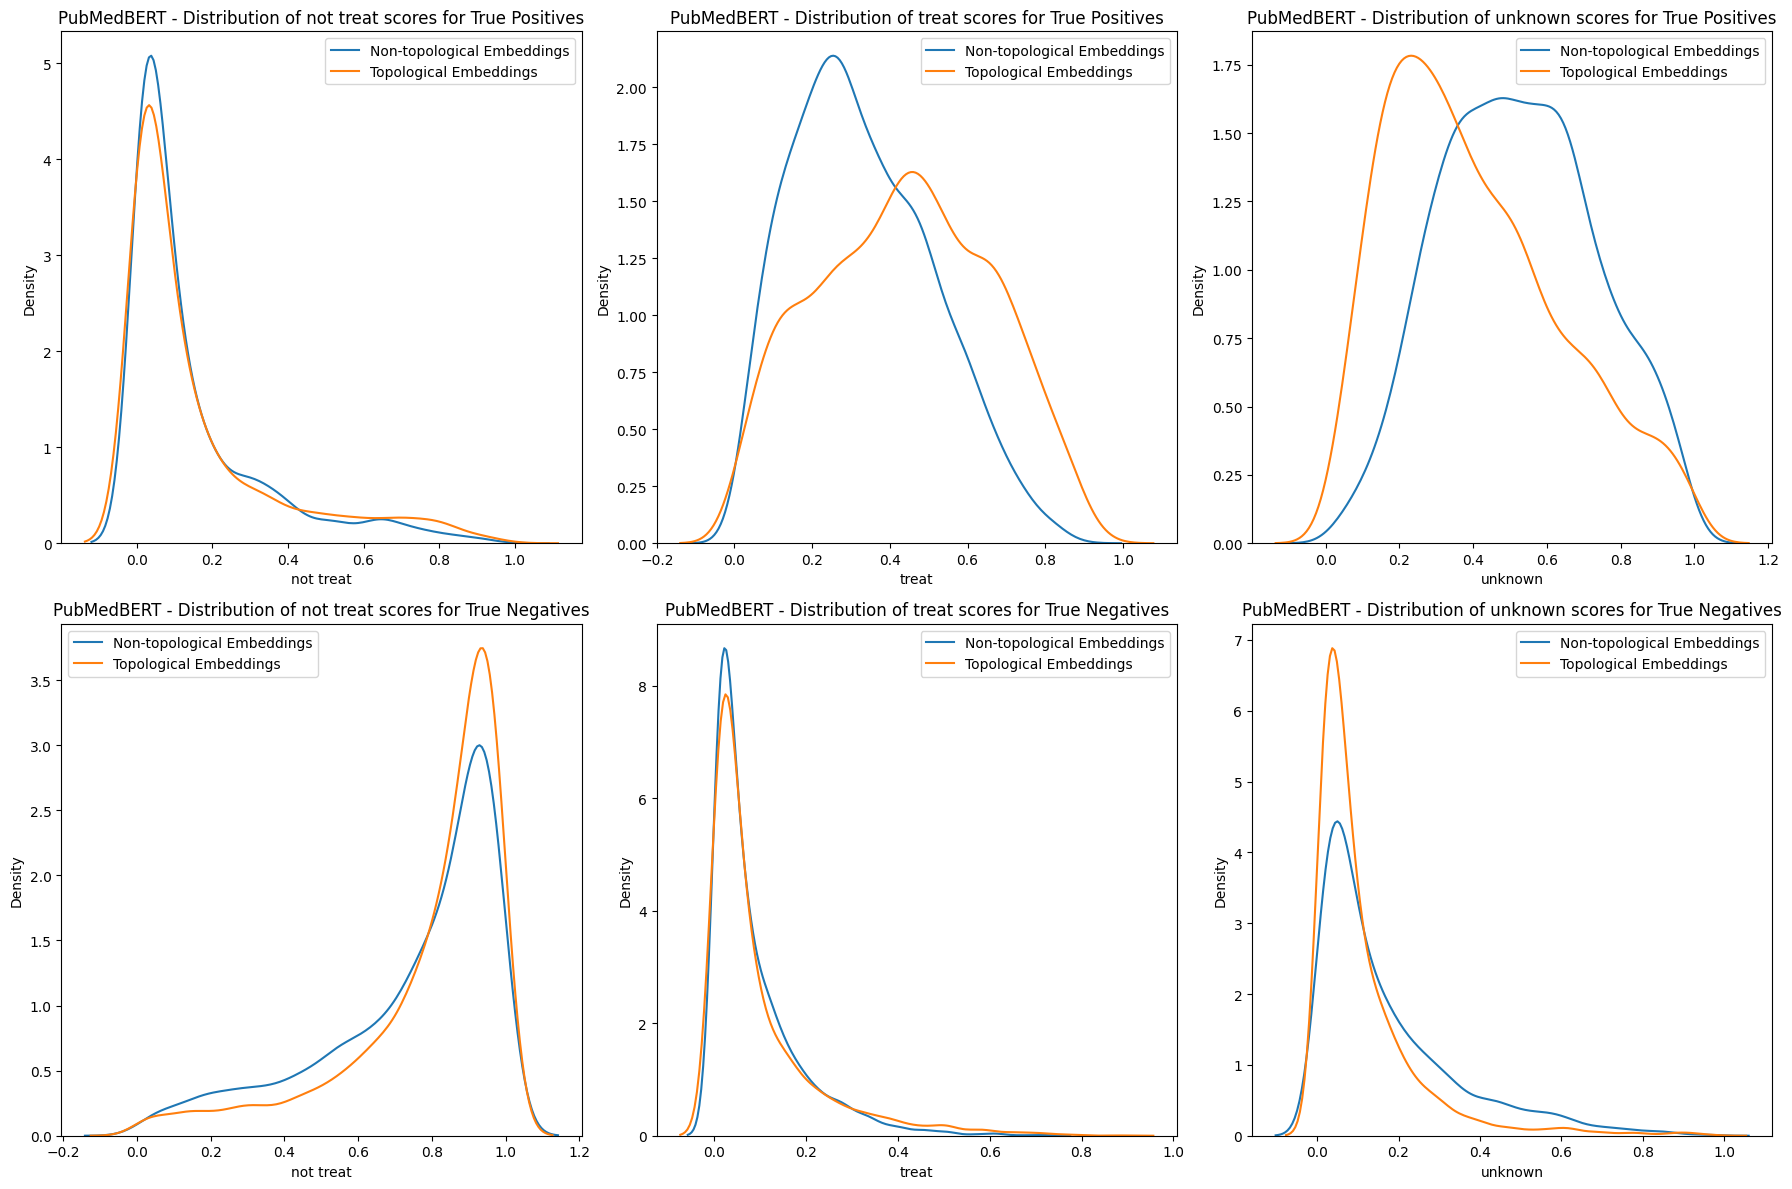

In [210]:
def plot_kde(ax, data, column, gt, title):
    sns.kdeplot(data=data.loc[data.GT==gt], x=column, ax=ax, label='Non-topological Embeddings')
    sns.kdeplot(data=pubmed_df_full_graph_2.loc[pubmed_df_full_graph_2.GT==gt], x=column, ax=ax, label='Topological Embeddings')
    ax.set_title(title)
    ax.legend()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

plot_kde(axes[0, 0], pubmed_df_full_2, 'not treat', 1, 'PubMedBERT - Distribution of not treat scores for True Positives')
plot_kde(axes[0, 1], pubmed_df_full_2, 'treat', 1, 'PubMedBERT - Distribution of treat scores for True Positives')
plot_kde(axes[0, 2], pubmed_df_full_2, 'unknown', 1, 'PubMedBERT - Distribution of unknown scores for True Positives')

plot_kde(axes[1, 0], pubmed_df_full_2, 'not treat', 0, 'PubMedBERT - Distribution of not treat scores for True Negatives')
plot_kde(axes[1, 1], pubmed_df_full_2, 'treat', 0, 'PubMedBERT - Distribution of treat scores for True Negatives')
plot_kde(axes[1, 2], pubmed_df_full_2, 'unknown', 0, 'PubMedBERT - Distribution of unknown scores for True Negatives')

plt.tight_layout()
plt.show()

We can see a clear effect of topological enrichment however it is not as large as one would hope which indicates that at this point, we don't really know whether the models perform well due to LLM performing.

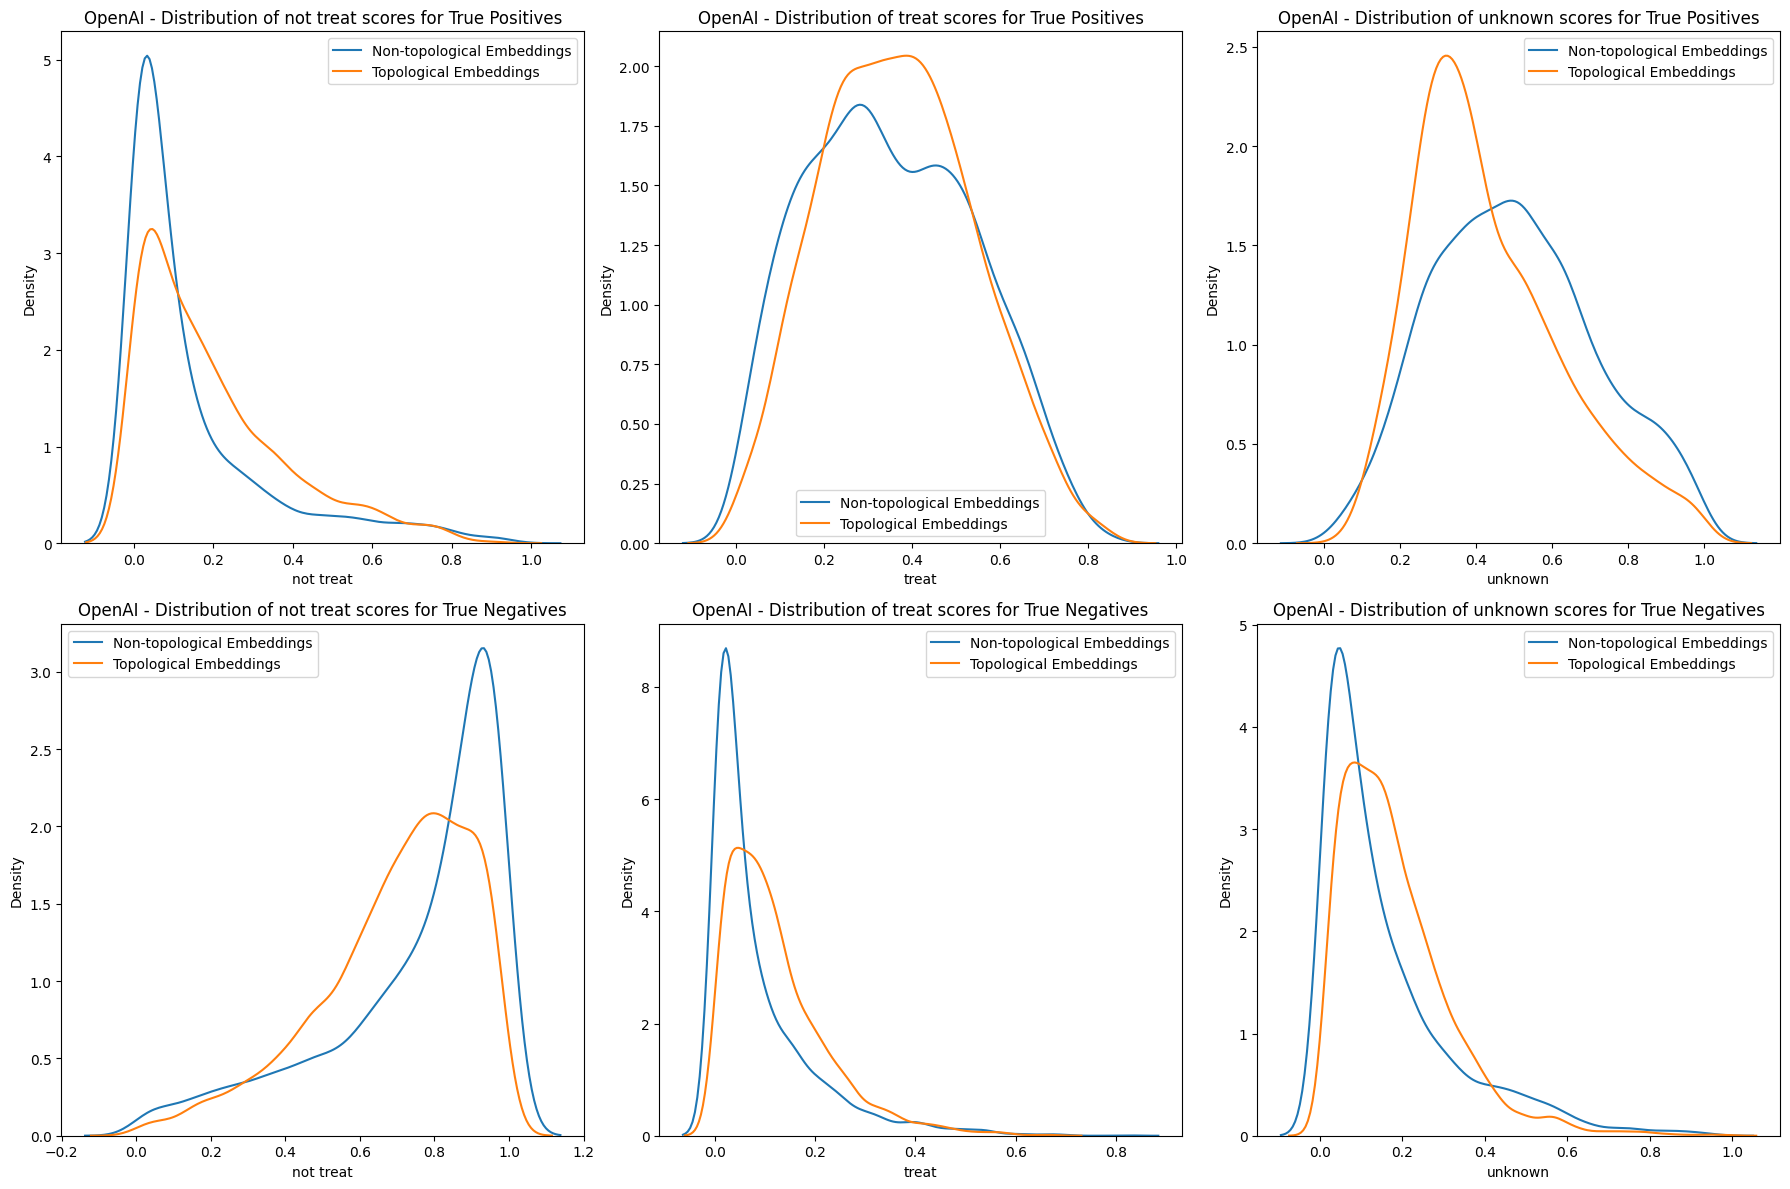

In [211]:
def plot_kde(ax, data, column, gt, title):
    sns.kdeplot(data=data.loc[data.GT==gt], x=column, ax=ax, label='Non-topological Embeddings')
    sns.kdeplot(data=openai_df_full_graph_2.loc[openai_df_full_graph_2.GT==gt], x=column, ax=ax, label='Topological Embeddings')
    ax.set_title(title)
    ax.legend()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

plot_kde(axes[0, 0], openai_df_full_2, 'not treat', 1, 'OpenAI - Distribution of not treat scores for True Positives')
plot_kde(axes[0, 1], openai_df_full_2, 'treat', 1, 'OpenAI - Distribution of treat scores for True Positives')
plot_kde(axes[0, 2], openai_df_full_2, 'unknown', 1, 'OpenAI - Distribution of unknown scores for True Positives')

plot_kde(axes[1, 0], openai_df_full_2, 'not treat', 0, 'OpenAI - Distribution of not treat scores for True Negatives')
plot_kde(axes[1, 1], openai_df_full_2, 'treat', 0, 'OpenAI - Distribution of treat scores for True Negatives')
plot_kde(axes[1, 2], openai_df_full_2, 'unknown', 0, 'OpenAI - Distribution of unknown scores for True Negatives')

plt.tight_layout()
plt.show()

# Overall conclusions

* The density plots here show clear superiority of LLM-based embeddings (for which distributions are much more skewed towards ground truth) vs spacy or scispacy (for which distributions are much more random). This is especially visible for scispacy embeddings which are simply crappy. **This also highlights that data leakage is very visible for LLMs however there is not that much difference between OpenAI and PubMedBERT in terms of downstream performance**

* **PCA transformation doesn’t impact the overall score distribution significantly**, therefore my previous hypothesis of PCA leading to information loss is not really suitable anymore. There is a difference between post and pre PCA but I wouldn’t worry about it too much if we care only about downstream performance of the model in terms of probability scores.

* Comparison of classifiers trained on topological embeddings vs trained on node embeddings for PubMedBERT does show some enrichment coming from knowledge graph but it’s rather subtle. This implies that **it’s very likely that our final model high performance is not due to graph but due to the embeddings encoding data leakage** (NOTE: for 100% certainty need to repeat with node and topological embeddings coming from the same run)